# NFL - 4th Down EDA

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import statsmodels.api as sm
import os

PROCESSED_DATA_PATH = Path("../data/processed/")

# set no limit on rows and columns displayed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# sns theme
mpl.rcParams.update({
    "font.size": 8, "axes.titlesize": 9, "axes.labelsize": 8,
    "xtick.labelsize": 7, "ytick.labelsize": 7, "legend.fontsize": 7,
    "axes.grid": True, "grid.linewidth": 0.4, "grid.alpha": 0.3,
    "axes.spines.top": False, "axes.spines.right": False,
    "figure.dpi": 150, "savefig.dpi": 300,
    "savefig.bbox": "tight", "savefig.pad_inches": 0.02
})
colors = {"go":"#7570b3", "fg":"#d95f02", "punt":"#1b9e77"}

WIDTH = 4.0
SAVE_FIGS = False
SAVE_DIR = "../reports/figures"
os.makedirs(SAVE_DIR, exist_ok=True)


## 01 Carga de Datos y Volumetría

### Volumetría
- Se analizan más de 2,700 juegos de la NFL entre las temporadas de 2014 a 2023
- El dataset cuenta con más de 40 mil jugadas de cuarta oportunidad para analizar

In [2]:
# Load dataset
nfl_4th = pd.read_parquet(PROCESSED_DATA_PATH / "4th_down_data.parquet")
nfl_4th = nfl_4th[nfl_4th["play_type_nfl"] != "PENALTY"]


print("Verification of Dataset:")
print(f" - Columns in the dataset: {nfl_4th.columns.nunique()}")
print(f" - Verify only 4th down plays are present: {nfl_4th['down'].unique()}")

print("\nVolume:")
print(f" - Number of unique games: {nfl_4th['game_id'].nunique()}")
print(f" - Number of 4th down plays: {len(nfl_4th)}")
print(f" - 4th down plays per game: {len(nfl_4th) / nfl_4th['game_id'].nunique():.2f}")
print(f" - Seasons covered: {nfl_4th['season'].min()} to {nfl_4th['season'].max()}")
print(f" - Regular vs Post Season ratio: {nfl_4th['season_type'].value_counts(normalize=True).round(2).to_dict()}")

Verification of Dataset:
 - Columns in the dataset: 117
 - Verify only 4th down plays are present: [4.]

Volume:
 - Number of unique games: 2725
 - Number of 4th down plays: 40655
 - 4th down plays per game: 14.92
 - Seasons covered: 2014 to 2023
 - Regular vs Post Season ratio: {'REG': 0.96, 'POST': 0.04}


## 02 Limpieza de Datos

### Dominios de variables


#### - Identificadores

In [3]:

identity_ids = [
    "play_id", "game_id", "nfl_api_id", "stadium_id", "nflverse_game_id",
]

# Duplicates in primary keys
dups = nfl_4th.duplicated(subset=["game_id", "play_id"]).sum()
print("Duplicate (game_id, play_id) pairs:", dups)
print("Unique 4th down plays:", nfl_4th[['game_id', 'play_id']].drop_duplicates().shape[0])
print("Nulls in primary keys:", nfl_4th[['game_id', 'play_id']].isna().sum().sum())

Duplicate (game_id, play_id) pairs: 0
Unique 4th down plays: 40655
Nulls in primary keys: 0


#### - Estado del Juego (Game State)

In [4]:
game_state = [
    "season", "season_type", "week", "game_date",
    "qtr", "quarter_seconds_remaining", "half_seconds_remaining",
    "game_seconds_remaining", "game_half", "down", "ydstogo",
    "yardline_100", "goal_to_go", "play_clock", "score_differential",
    "posteam_timeouts_remaining", "defteam_timeouts_remaining",
]

print("Unique seasons:", nfl_4th["season"].unique())
print("Nulls in game state variables:", nfl_4th[game_state].isna().sum().sum())
print("Duplicated game_state combinations:", nfl_4th[game_state].duplicated().sum())

Unique seasons: [2014 2015 2016 2017 2018 2019 2020 2021 2022 2023]
Nulls in game state variables: 0
Duplicated game_state combinations: 53


#### - Team Identity

Unique teams: 32
Nulls in team identity variables: 0
Plot Team values counts:


<Axes: >

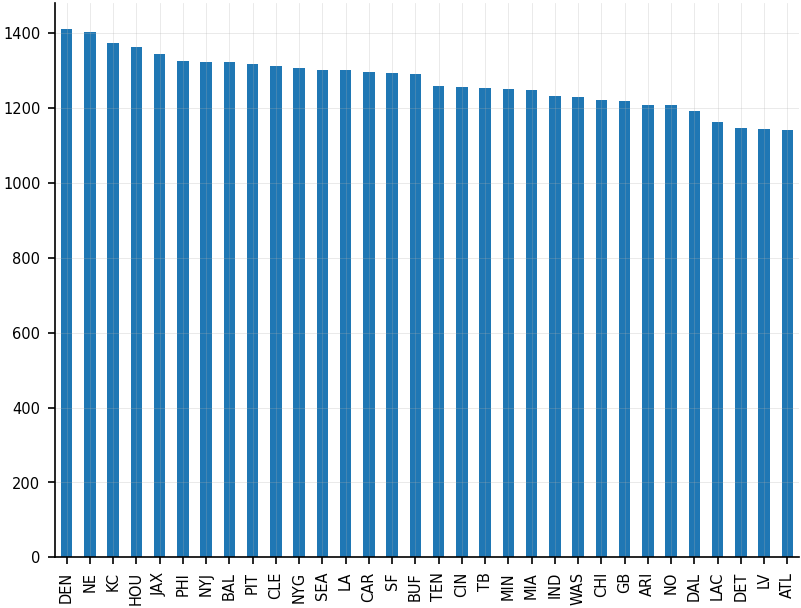

In [5]:
teams = [
    "home_team", "away_team", "posteam", "defteam",
    "posteam_type", "side_of_field", "home_opening_kickoff",
]

print("Unique teams:", nfl_4th["home_team"].nunique())
print("Nulls in team identity variables:", nfl_4th[teams].isna().sum().sum())
print("Plot Team values counts:")
nfl_4th["home_team"].value_counts().plot(kind="bar")

#### - Ambiente de Juego

In [6]:
environment = [
    "roof", "surface", "temp", "wind",
]

print("Stadium data overview:")
print(" - Unique stadiums:", nfl_4th["stadium"].nunique())
print(" - Type of stadium roofs count:", nfl_4th["roof"].value_counts().to_dict())
print(" - Type of playing surfaces count:", nfl_4th["surface"].value_counts().to_dict())

roof_map = {
    "closed": "indoor",
    "dome": "indoor",
    "outdoors": "open_air",
    "open": "open_air",
}
surface_map = {
    "grass": "natural",
    "grass ": "natural",
    "fieldturf": "artificial",
    "sportturf": "artificial",
    "matrixturf": "artificial",
    "astroturf": "artificial",
    "astroplay": "artificial",
    "a_turf": "artificial",
}

nfl_4th["roof"] = nfl_4th["roof"].map(roof_map)
nfl_4th["surface"] = nfl_4th["surface"].map(surface_map)

# fill missing surface and roof values with mode by stadium
nfl_4th["roof"] = nfl_4th.groupby("stadium")["roof"].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else nfl_4th["roof"].mode().iloc[0])
)
nfl_4th["surface"] = nfl_4th.groupby("stadium")["surface"].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else nfl_4th["surface"].mode().iloc[0])
)

print("\nWeather conditions overview:")
print(" - Missing Temperature values by roof:", nfl_4th["temp"].isna().groupby(nfl_4th["roof"]).sum().to_dict())
print(" - Mean Temperature by roof:", nfl_4th.groupby("roof")["temp"].mean().to_dict())
print("\n - Missing Wind values by roof:", nfl_4th["wind"].isna().groupby(nfl_4th["roof"]).sum().to_dict())
print(" - Mean Wind by roof:", nfl_4th.groupby("roof")["wind"].mean().to_dict())

# If roof is indoor and wind/temp is null, set wind and temp to 0 and 70 respectively
nfl_4th.loc[nfl_4th["roof"] == "indoor", "wind"] = nfl_4th.loc[nfl_4th["roof"] == "indoor", "wind"].fillna(0)
nfl_4th.loc[nfl_4th["roof"] == "indoor", "temp"] = nfl_4th.loc[nfl_4th["roof"] == "indoor", "temp"].fillna(70)

nfl_4th["wind"] = pd.cut(
    nfl_4th["wind"],
    bins=[-1, 0, 5, 10, 15, np.inf],
    labels=["Calm", "Light", "Moderate", "Windy", "VeryWindy"]
)

nfl_4th["temp"] = pd.cut(
    nfl_4th["temp"],
    bins=[-np.inf, 32, 45, 60, 75, np.inf],
    labels=["Frigid", "Cold", "Cool", "Mild", "Warm/Hot"]
)

# fill missing wind and temp values with mode in outdoor stadiums
nfl_4th["wind"] = nfl_4th.groupby("roof")["wind"].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else nfl_4th["wind"].mode().iloc[0])
)
nfl_4th["temp"] = nfl_4th.groupby("roof")["temp"].transform(
    lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else nfl_4th["temp"].mode().iloc[0])
)

# set ordinal categories
nfl_4th["wind"] = nfl_4th["wind"].astype(
    pd.api.types.CategoricalDtype(categories=["Calm", "Light", "Moderate", "Windy", "VeryWindy"], ordered=True)
)
nfl_4th["temp"] = nfl_4th["temp"].astype(
    pd.api.types.CategoricalDtype(categories=["Frigid", "Cold", "Cool", "Mild", "Warm/Hot"], ordered=True)
)

print("\n\n =========== Variable Simplification ===========\n")
print(" - Type of stadium roofs:", nfl_4th["roof"].value_counts().to_dict())
print(" - Type of playing surfaces:", nfl_4th["surface"].value_counts().to_dict())
print(" - Wind conditions:", nfl_4th["wind"].value_counts().to_dict())
print(" - Temperature conditions:", nfl_4th["temp"].value_counts().to_dict())

print("\nWeather conditions overview:")
print(" - Missing Temperature values by roof:", nfl_4th["temp"].isna().groupby(nfl_4th["roof"]).sum().to_dict())
print(" - Missing Wind values by roof:", nfl_4th["wind"].isna().groupby(nfl_4th["roof"]).sum().to_dict())

Stadium data overview:
 - Unique stadiums: 43
 - Type of stadium roofs count: {'outdoors': 29351, 'dome': 5413, 'closed': 5106, 'open': 785}
 - Type of playing surfaces count: {'grass': 21733, 'fieldturf': 10245, 'sportturf': 2120, 'matrixturf': 1931, 'astroturf': 1424, 'grass ': 1356, 'a_turf': 985, '': 597, 'astroplay': 264}

Weather conditions overview:
 - Missing Temperature values by roof: {'indoor': 10519, 'open_air': 2538}
 - Mean Temperature by roof: {'indoor': nan, 'open_air': 57.49079513549805}

 - Missing Wind values by roof: {'indoor': 10519, 'open_air': 2538}
 - Mean Wind by roof: {'indoor': nan, 'open_air': 8.329298973083496}


 =========== Variable Simplification ===========

 - Type of stadium roofs: {'open_air': 30136, 'indoor': 10519}
 - Type of playing surfaces: {'natural': 23442, 'artificial': 17213}
 - Wind conditions: {'Moderate': 13479, 'Calm': 11638, 'Light': 7606, 'Windy': 5549, 'VeryWindy': 2383}
 - Temperature conditions: {'Mild': 18077, 'Cool': 10402, 'Cold'

#### - Variables de NFL4th 

In [7]:
nfl4th_outputs = [
    "go_boost",
    "first_down_prob",
    "wp_fail",
    "wp_succeed",
    "go_wp",
    "fg_make_prob",
    "miss_fg_wp",
    "make_fg_wp",
    "fg_wp",
    "punt_wp",
]

print("\nNFL4th outputs overview:")
print(" - Nulls in NFL4th output variables:\n", nfl_4th[nfl4th_outputs].isna().sum())

# fill first_down_prob and wp_succeed nulls with median
nfl_4th["first_down_prob"] = nfl_4th["first_down_prob"].fillna(nfl_4th["first_down_prob"].median())
nfl_4th["wp_succeed"] = nfl_4th["wp_succeed"].fillna(nfl_4th["wp_succeed"].median())

print("\n - Nulls in NFL4th output variables after imputation:\n", nfl_4th[nfl4th_outputs].isna().sum())


NFL4th outputs overview:
 - Nulls in NFL4th output variables:
 go_boost               0
first_down_prob        1
wp_fail                0
wp_succeed             1
go_wp                  0
fg_make_prob           0
miss_fg_wp             0
make_fg_wp             0
fg_wp                  0
punt_wp            10362
dtype: int64

 - Nulls in NFL4th output variables after imputation:
 go_boost               0
first_down_prob        0
wp_fail                0
wp_succeed             0
go_wp                  0
fg_make_prob           0
miss_fg_wp             0
make_fg_wp             0
fg_wp                  0
punt_wp            10362
dtype: int64


#### - EDA y resultados de la jugada

In [8]:
eda_helpers = [
    "ep", "wp",
]

print("Nulls in EDA helper variables:\n", nfl_4th[eda_helpers].isna().sum())

Nulls in EDA helper variables:
 ep    0
wp    0
dtype: int64


In [9]:
observed_outcomes = ["play_type_nfl"]
print("Nulls in observed outcome variables:\n", nfl_4th[observed_outcomes].isna().sum())

# fill play_type_nfl where "UNSPECIFIED" with nfl_4th["play_type"] with npl.where
nfl_4th["play_type_nfl"] = np.where(
    nfl_4th["play_type_nfl"] == "UNSPECIFIED",
    nfl_4th["play_type"].str.upper(),
    nfl_4th["play_type_nfl"]
)

# fill Nulls with conditions if contains ("Punt" -> "PUNT", "Field Goal" -> "FIELD_GOAL", "Pass" -> "PASS", "Run" -> "RUN")
nfl_4th["play_type_nfl"] = np.where(
    nfl_4th["play_type_nfl"].isna() & nfl_4th["desc"].str.contains("Punt", na=False),
    "PUNT",
    np.where(
        nfl_4th["play_type_nfl"].isna() & nfl_4th["desc"].str.contains("Field Goal", na=False),
        "FIELD_GOAL",
        np.where(
            nfl_4th["play_type_nfl"].isna() & nfl_4th["desc"].str.contains("Pass", na=False),
            "PASS",
            np.where(
                nfl_4th["play_type_nfl"].isna() & nfl_4th["desc"].str.contains("Run", na=False),
                "RUN",
                nfl_4th["play_type_nfl"]
            )
        )
    )
)

nfl_4th["play_type_nfl"] = nfl_4th["play_type_nfl"].fillna("NO_PLAY")

play_map = {
    "PUNT": "PUNT",
    "FIELD_GOAL": "FIELD_GOAL",
    "PASS": "GO",
    "RUSH": "GO",
    "RUN": "GO",
    "SACK": "GO",
    "INTERCEPTION": "GO",
    "NO_PLAY": "GO",
    "FUMBLE_RECOVERED_BY_OPPONENT": "GO",
}
nfl_4th["play_type_nfl"] = nfl_4th["play_type_nfl"].map(play_map)

print("Nulls in play_type_nfl after imputation:", nfl_4th["play_type_nfl"].isna().sum())
print("\nPlay Type distributions:\n", nfl_4th["play_type_nfl"].value_counts())


Nulls in observed outcome variables:
 play_type_nfl    0
dtype: int64
Nulls in play_type_nfl after imputation: 0

Play Type distributions:
 PUNT          23455
FIELD_GOAL     9609
GO             7591
Name: play_type_nfl, dtype: int64


## 03 EDA

In [10]:
# --- 1A. Estimated FG distance (from yardline_100): snap 7 + endzone 10 = 17 yards
nfl_4th = nfl_4th.copy()
nfl_4th["est_fg_distance"] = (nfl_4th["yardline_100"] + 17).clip(lower=0)

# --- 1B. Map actual play to triad (GO / FIELD_GOAL / PUNT)
actual_map = {
    "GO": "GO",
    "FIELD_GOAL": "FIELD_GOAL",
    "PUNT": "PUNT",
}
# If your column already uses exactly these three labels, this is a no-op:
nfl_4th["actual_action"] = nfl_4th["play_type_nfl"].map(actual_map)

# --- 1C. Masked action WPs (do NOT impute punt)
nfl_4th["go_wp_m"]   = nfl_4th["go_wp"]
nfl_4th["fg_wp_m"]   = nfl_4th["fg_wp"]
nfl_4th["punt_wp_m"] = nfl_4th["punt_wp"]  # remains NaN if punt is not a viable action

# How many actions are available per play?
nfl_4th["n_actions_available"] = (
    nfl_4th[["go_wp_m", "fg_wp_m", "punt_wp_m"]].notna().sum(axis=1)
)

# --- 1D. Model action (argmax among available actions)
def pick_action(row):
    vals = {"GO": row["go_wp_m"], "FIELD_GOAL": row["fg_wp_m"], "PUNT": row["punt_wp_m"]}
    # drop NaNs
    vals = {k: v for k, v in vals.items() if pd.notna(v)}
    if not vals:
        return np.nan
    return max(vals, key=vals.get)

nfl_4th["model_action"] = nfl_4th.apply(pick_action, axis=1)

# --- 1E. Margin between top-1 and top-2 (closeness of the decision)
def margin_top2(row):
    xs = [row["go_wp_m"], row["fg_wp_m"], row["punt_wp_m"]]
    xs = [v for v in xs if pd.notna(v)]
    if len(xs) < 2:
        return np.nan
    xs_sorted = sorted(xs, reverse=True)
    return xs_sorted[0] - xs_sorted[1]

nfl_4th["margin_top2"] = nfl_4th.apply(margin_top2, axis=1)

# --- 1F. Context bins for heatmaps / grouped plots
nfl_4th["ytg_bin"] = pd.cut(
    nfl_4th["ydstogo"],
    bins=[0, 2, 5, 10, 100],
    labels=["1-2", "3-5", "6-10", "11+"],
    right=True,
    include_lowest=True
)

nfl_4th["yardline_bin"] = pd.cut(
    nfl_4th["yardline_100"],
    bins=[0, 20, 40, 60, 80, 100],
    labels=["RZ 0-20", "20-40", "40-60", "60-80", "80-100"],
    right=False,
    include_lowest=True
)

nfl_4th["clock_bucket_qtr"] = pd.cut(
    nfl_4th["quarter_seconds_remaining"] / 60.0,
    bins=[0, 2, 7, 15],
    labels=["0-2 min", "2-7 min", "7-15 min"],
    right=True,
    include_lowest=True
)

# Environment is simplified:
# roof: {'indoor','open_air'}, surface: {'natural','artificial'}
# wind: {'Calm','Light','Moderate','Windy','VeryWindy'}
# temp: {'Frigid','Cold','Cool','Mild','Warm/Hot'}


#### - Volumetría y disponibilidad de jugadas

Unique plays: 40655
Triad counts (actual):
 PUNT          23455
FIELD_GOAL     9609
GO             7591
Name: actual_action, dtype: int64

How many actions available per play:
2    10362
3    30293
Name: n_actions_available, dtype: int64

Punt WP NA rate (means punt not viable): 0.2548763989669167


/var/folders/lm/z70n500n5yz1798_6ckkxp300000gn/T/ipykernel_73009/1313047318.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


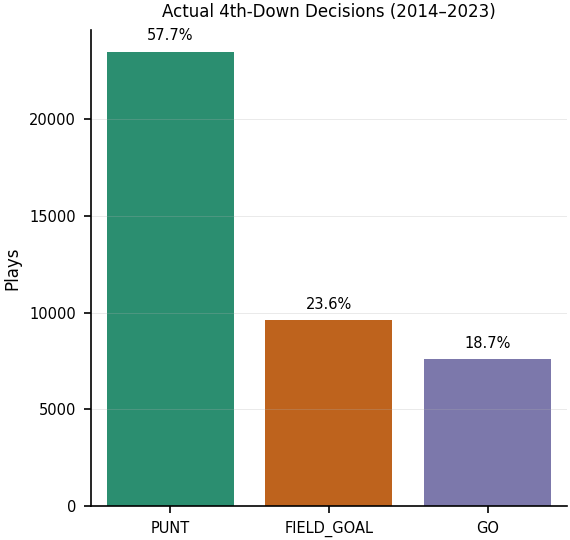

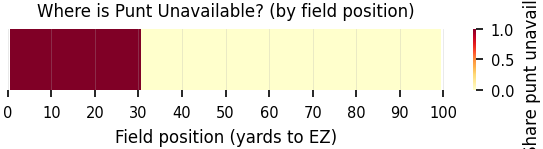

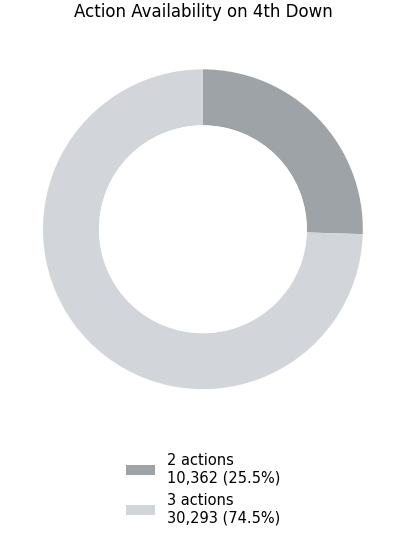

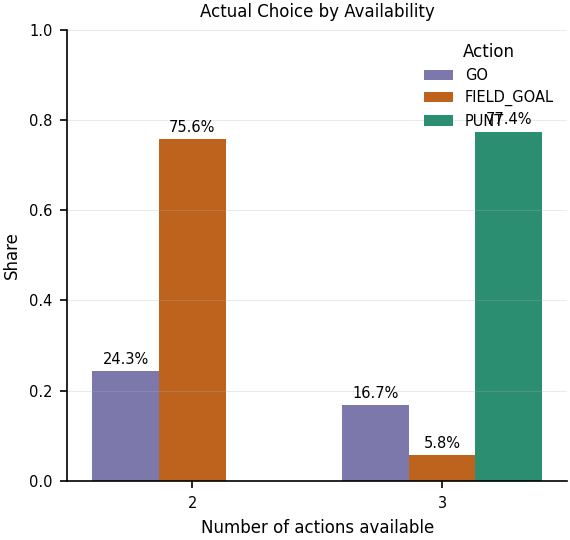

In [11]:
print("Unique plays:", len(nfl_4th))
print("Triad counts (actual):\n", nfl_4th["actual_action"].value_counts(dropna=False))
print("\nHow many actions available per play:")
print(nfl_4th["n_actions_available"].value_counts().sort_index())

print("\nPunt WP NA rate (means punt not viable):",
      nfl_4th["punt_wp_m"].isna().mean())


palette_actions = {"GO": colors["go"], "FIELD_GOAL": colors["fg"], "PUNT": colors["punt"]}

# =========================================================
# PLOT A — Actual 4th-Down Decisions (Counts + % labels)
# =========================================================
order = ["PUNT", "FIELD_GOAL", "GO"]
counts = (nfl_4th["actual_action"]
          .value_counts()
          .reindex(order)
          .rename_axis("action")
          .reset_index(name="count"))
counts["share"] = counts["count"] / counts["count"].sum()

fig, ax = plt.subplots(figsize=(WIDTH, WIDTH*0.95))
sns.barplot(
    data=counts, x="action", y="count", order=order,
    palette=[palette_actions[a] for a in order], ax=ax
)

ax.set_title("Actual 4th-Down Decisions (2014–2023)", fontsize=8)
ax.set_xlabel("")
ax.set_ylabel("Plays")

# annotate percentages above bars (small, tidy)
offset = counts["count"].max() * 0.01
for p in ax.patches:
    h = p.get_height()
    if h > 0:
        ax.annotate(f"{(h / counts['count'].sum())*100:.1f}%",
                    (p.get_x() + p.get_width()/2, h + offset),
                    ha="center", va="bottom", fontsize=7, xytext=(0, 2),
                    textcoords="offset points")

fig.tight_layout()
if 'SAVE_FIGS' in globals() and SAVE_FIGS:
    fig.savefig(os.path.join(SAVE_DIR, "actual_decisions_counts.png"))
plt.show()

# =========================================================
# PUNT UNAVAILABLE — 1D GRADIENT ACROSS YARDLINE_100 (DROP YTG AXIS)
# =========================================================
df = nfl_4th.copy()
df["punt_unavailable"] = df["punt_wp"].isna().astype(int)

# Share by exact yardline_100 (0–100). Cast to int yards for a smooth gradient strip.
yl_int = df["yardline_100"].round().astype(int).clip(0, 100)
share_by_yard = (df.assign(yl=yl_int)
                   .groupby("yl")["punt_unavailable"]
                   .mean()
                   .reindex(range(0, 101)))  # ensure full 0..100 coverage

# Make a 1×101 "strip" for a single-axis heatmap
grad_df = pd.DataFrame([share_by_yard.values], index=["share"], columns=range(0, 101))

fig, ax = plt.subplots(figsize=(WIDTH, WIDTH*0.30))
sns.heatmap(
    grad_df, cmap="YlOrRd", vmin=0, vmax=1, cbar_kws={"label": "Share punt unavailable"},
    ax=ax, yticklabels=False, xticklabels=10  # show every 10 yards
)

ax.set_title("Where is Punt Unavailable? (by field position)", fontsize=8)
ax.set_xlabel("Field position (yards to EZ)")
ax.set_ylabel("")

# Clean up spines for a strip look
for spine in ["left", "right", "top", "bottom"]:
    ax.spines[spine].set_visible(False)

fig.tight_layout()
if 'SAVE_FIGS' in globals() and SAVE_FIGS:
    fig.savefig(os.path.join(SAVE_DIR, "punt_unavailable_yardline_gradient.png"))
plt.show()

# =========================================================
# PLOT B — Availability of Actions (Donut)
# =========================================================
avail = (nfl_4th["n_actions_available"]
         .value_counts()
         .reindex([2, 3])
         .rename_axis("n_actions")
         .reset_index(name="count"))
avail["share"] = avail["count"] / avail["count"].sum()

fig, ax = plt.subplots(figsize=(WIDTH, WIDTH*0.95))
vals = avail["count"].values
labels = [f"{n} actions\n{c:,} ({s*100:.1f}%)"
          for n, c, s in zip(avail["n_actions"], avail["count"], avail["share"])]

# neutral greys to keep action colors reserved for actions
wedge_colors = ["#9ea3a8", "#d2d6da"]
wedges, _ = ax.pie(
    vals, startangle=90, counterclock=False,
    wedgeprops=dict(width=0.35), colors=wedge_colors
)
# white center for the donut
centre_circle = plt.Circle((0, 0), 0.65, fc="white")
ax.add_artist(centre_circle)
ax.set_aspect("equal")

ax.set_title("Action Availability on 4th Down", fontsize=8)
ax.legend(wedges, labels, loc="center", bbox_to_anchor=(0.5, -0.15),
          ncol=1, frameon=False)

fig.tight_layout()
if 'SAVE_FIGS' in globals() and SAVE_FIGS:
    fig.savefig(os.path.join(SAVE_DIR, "availability_donut.png"))
plt.show()

# =========================================================
# PLOT D — Actual Choice by Availability (Shares, colored by action)
# =========================================================
subset = nfl_4th[nfl_4th["n_actions_available"].isin([2, 3])].copy()
prop = (subset
        .groupby(["n_actions_available", "actual_action"], group_keys=False)
        .size()
        .groupby(level=0, group_keys=False)
        .apply(lambda s: s / s.sum())
        .rename("prop")
        .reset_index())

order_actions = ["GO", "FIELD_GOAL", "PUNT"]

fig, ax = plt.subplots(figsize=(WIDTH, WIDTH*0.95))
sns.barplot(
    data=prop, x="n_actions_available", y="prop", hue="actual_action",
    hue_order=order_actions, palette=palette_actions, ax=ax
)

ax.set_title("Actual Choice by Availability", fontsize=8)
ax.set_xlabel("Number of actions available")
ax.set_ylabel("Share")
ax.set_ylim(0, 1)
ax.legend(title="Action", loc="upper right", frameon=False)

# annotate bars with share %
for p in ax.patches:
    h = p.get_height()
    if h > 0.01:
        ax.annotate(f"{h*100:.1f}%",
                    (p.get_x() + p.get_width()/2, h),
                    ha="center", va="bottom", fontsize=7, xytext=(0, 2),
                    textcoords="offset points")

fig.tight_layout()
if 'SAVE_FIGS' in globals() and SAVE_FIGS:
    fig.savefig(os.path.join(SAVE_DIR, "actual_choice_by_availability.png"))
plt.show()

- Más de 40,000 jugadas (57% Punt, 23% FG Attempt, 18% GO)
- En el 74% de los escenarios se tienen 3 posibles jugadas disponibles, distancia mínima de despeje

#### - Acuerdo entre las decisiones del coach y el diferencial de probabilidad de victoria

In [12]:
conf = pd.crosstab(nfl_4th["actual_action"], nfl_4th["model_action"], normalize="index").round(3)
display(conf)

# Raw counts too:
display(pd.crosstab(nfl_4th["actual_action"], nfl_4th["model_action"]))


model_action,FIELD_GOAL,GO,PUNT
actual_action,,,
FIELD_GOAL,0.682,0.309,0.009
GO,0.113,0.785,0.102
PUNT,0.017,0.342,0.641


model_action,FIELD_GOAL,GO,PUNT
actual_action,,,
FIELD_GOAL,6554,2967,88
GO,861,5958,772
PUNT,400,8021,15034


- Overall agreement ~67.8% (27,546 / 40,655). Diagonal by class: GO 78.5%, FG 68.2%, PUNT 64.1% → the model aligns best on GO decisions and least on punts.

- Model is much more aggressive than coaches.
    - Predicted GO ~41.7% (16,946) vs actual GO ~18.7% (7,591).
    - Predicted PUNT ~39.1% (15,894) vs actual PUNT ~57.7% (23,455).
    - Predicted FG ~19.2% (7,815) vs actual FG ~23.7% (9,609).

- Where disagreements cluster:
    - When coaches punted, the model said GO in 34.2% of those cases (8,021 / 23,455).
    - When coaches kicked FG, the model said GO in 30.9% (2,967 / 9,609).
    - When coaches went for it, the model still preferred FG or PUNT in ~21.5% (1,633 / 7,591).

- Asymmetry is clear: Coaches favor PUNT far more than the model (64.1% agreement on punts, but 34.2% of punts are flagged as GO by the model), while GO has the highest alignment (78.5%) — suggesting many “go” situations are robust, but a large set of “punt” situations are borderline where the model sees value in aggression.

- FG vs GO boundary is tight: ~31% of coach FGs are flagged GO by the model, consistent with a model that values expected WP gains from conversion over 3 points in many mid-range spots.

In [13]:
# Which action is best by WP?
best_action = nfl_4th[["go_wp_m","fg_wp_m","punt_wp_m"]].idxmax(axis=1)
best_action = best_action.replace({"go_wp_m":"GO","fg_wp_m":"FIELD_GOAL","punt_wp_m":"PUNT"})
nfl_4th["best_action"] = best_action

pivot = (nfl_4th
         .pivot_table(index="yardline_bin", columns="ytg_bin",
                      values="best_action", aggfunc=lambda s: s.value_counts(normalize=True).idxmax()))
display(pivot)

# Also show % of best being FG/PUNT/GO per bin
share = (nfl_4th
         .groupby(["yardline_bin","ytg_bin","best_action"], group_keys=False)
         .size()
         .groupby(level=[0,1], group_keys=False).apply(lambda s: s / s.sum())
         .rename("share")
         .reset_index())
display(share.head(10))


ytg_bin,1-2,3-5,6-10,11+
yardline_bin,,,,
RZ 0-20,GO,FIELD_GOAL,FIELD_GOAL,FIELD_GOAL
20-40,GO,GO,FIELD_GOAL,FIELD_GOAL
40-60,GO,GO,PUNT,PUNT
60-80,GO,GO,PUNT,PUNT
80-100,GO,GO,PUNT,PUNT


,yardline_bin,ytg_bin,best_action,share
0,RZ 0-20,1-2,FIELD_GOAL,0.174269
1,RZ 0-20,1-2,GO,0.825731
2,RZ 0-20,1-2,PUNT,0.000000
3,RZ 0-20,3-5,FIELD_GOAL,0.512182
4,RZ 0-20,3-5,GO,0.487818
5,RZ 0-20,3-5,PUNT,0.000000
6,RZ 0-20,6-10,FIELD_GOAL,0.749493
7,RZ 0-20,6-10,GO,0.250507
8,RZ 0-20,6-10,PUNT,0.000000
9,RZ 0-20,11+,FIELD_GOAL,0.928969


No punts in the red zone (0–20 yds to go to the EZ).
Across all YTG bins in RZ 0–20, the model never recommends punt (share = 0.000).

Short yardage (≤5 yds): “GO” almost everywhere.

RZ 0–20, 1–2 yds: GO 82.6%, FG 17.4%.

RZ 0–20, 3–5 yds: essentially a coin flip (FG 51.2%, GO 48.8%).

20–40 and 40–100: the table shows GO for both 1–2 and 3–5 across all non-RZ bins.

Medium yardage (6–10 yds): context flips the action.

RZ 0–20: FG is preferred (74.9% FG, 25.1% GO).

Outside RZ (20–100): PUNT becomes preferred (per the grid: 40–60, 60–80, 80–100 all say PUNT; 20–40 says FG, see note below).

Long yardage (11+ yds): FG only in the RZ; otherwise PUNT.

RZ 0–20: FG 92.9%.

20–100: PUNT is recommended in all non-RZ bins (per the grid).

In [14]:
agg_margin = (nfl_4th
              .groupby(["yardline_bin","ytg_bin"])["margin_top2"]
              .mean()
              .unstack(1)
              .round(3))
display(agg_margin)

print("Overall median margin:", nfl_4th["margin_top2"].median().round(4))


ytg_bin,1-2,3-5,6-10,11+
yardline_bin,,,,
RZ 0-20,0.032,0.018,0.026,0.041
20-40,0.025,0.015,0.018,0.026
40-60,0.029,0.014,0.011,0.019
60-80,0.020,0.010,0.016,0.031
80-100,0.018,0.008,0.015,0.031


Overall median margin: 0.0128


In [15]:
# Share of best action by wind category
wind_best = (nfl_4th
             .groupby(["wind","best_action"], group_keys=True)
             .size()
             .groupby(level=0, group_keys=False).apply(lambda s: s / s.sum())
             .rename("share")
             .reset_index())

# Share of best action by temp category
temp_best = (nfl_4th
             .groupby(["temp","best_action"], group_keys=False)
             .size()
             .groupby(level=0, group_keys=False).apply(lambda s: s / s.sum())
             .rename("share")
             .reset_index())

display(wind_best.head(10))
display(temp_best.head(10))


,wind,best_action,share
0,Calm,FIELD_GOAL,0.196597
1,Calm,GO,0.444492
2,Calm,PUNT,0.358910
3,Light,FIELD_GOAL,0.184723
4,Light,GO,0.412438
5,Light,PUNT,0.402840
6,Moderate,FIELD_GOAL,0.192670
7,Moderate,GO,0.409897
8,Moderate,PUNT,0.397433
9,Windy,FIELD_GOAL,0.187782


,temp,best_action,share
0,Frigid,FIELD_GOAL,0.207444
1,Frigid,GO,0.402846
2,Frigid,PUNT,0.389710
3,Cold,FIELD_GOAL,0.197458
4,Cold,GO,0.403021
5,Cold,PUNT,0.399521
6,Cool,FIELD_GOAL,0.194482
7,Cool,GO,0.403480
8,Cool,PUNT,0.402038
9,Mild,FIELD_GOAL,0.192289


Wind (Calm → Light/Moderate shown)

GO share drops as wind picks up: 44.4% (Calm) → ~41% (Light/Moderate).

PUNT share rises in the same shift: 35.9% → ~40%.

FG share stays ~flat (~18–20%).
Interpretation: with more wind the policy nudges from GO → PUNT, not toward FG. (Makes sense: wind hurts the “go” path’s passing more broadly; long FGs are also wind-sensitive, so the safer default becomes punt.)

Temperature (Frigid → Cool → Mild shown)

Shares barely move: GO ~40%, PUNT ~39–40%, FG ~19–21%.

Slight FG uptick in Frigid (20.7%) vs Mild (19.2%), but differences are small.
Interpretation: unconditional temperature effects are weak; field position & YTG dominate the decision. Any temp effect likely appears at longer FG distances only.

In [16]:
# Bin estimated FG distance
nfl_4th["fg_dist_bin"] = pd.cut(
    nfl_4th["est_fg_distance"],
    bins=[0,30,35,40,45,50,55,60,80],
    labels=["<30","30-34","35-39","40-44","45-49","50-54","55-59","60+"],
    right=False
)

# Share of MODEL recommending FG by distance
fg_share_model = (nfl_4th
                  .groupby("fg_dist_bin")["model_action"]
                  .apply(lambda s: (s=="FIELD_GOAL").mean())
                  .round(3))

# Share of ACTUAL FG by distance
fg_share_actual = (nfl_4th
                   .groupby("fg_dist_bin")["actual_action"]
                   .apply(lambda s: (s=="FIELD_GOAL").mean())
                   .round(3))

# Average FG make probability by distance (from nfl4th)
fg_make_by_dist = nfl_4th.groupby("fg_dist_bin")["fg_make_prob"].mean().round(3)

display(pd.DataFrame({
    "fg_model_share": fg_share_model,
    "fg_actual_share": fg_share_actual,
    "fg_make_prob_avg": fg_make_by_dist
}))


,fg_model_share,fg_actual_share,fg_make_prob_avg
fg_dist_bin,,,
<30,0.438,0.694,0.976
30-34,0.703,0.794,0.932
35-39,0.700,0.817,0.880
40-44,0.648,0.793,0.805
45-49,0.582,0.742,0.717
50-54,0.466,0.531,0.612
55-59,0.182,0.085,0.437
60+,0.006,0.002,0.030


Make prob drops cleanly with distance (0.98 → 0.03 from <30 to 60+). Calibration looks monotonic and sensible.

Coaches kick more often than the model across standard ranges (<55 yds).
Biggest gaps:

40–44 yds: model 0.648 vs actual 0.793 (−0.145)

45–49 yds: 0.582 vs 0.742 (−0.160)

35–39 yds: 0.700 vs 0.817 (−0.117)
Interpretation: in the mid-range, the model more often prefers GO or PUNT because the WP gain from a TD (or field position) can beat the 3 points, even with decent make rates.

Short range (<30): coaches kick ~69% vs model ~44%. The model is more aggressive here—preferring GO on short yardage despite near-automatic FGs.

Very long range (55–59): model kicks more than coaches (0.182 vs 0.085). Likely end-of-half/game spots where a long FG can rival the value of a punt.

60+: both essentially avoid FGs (near zero), aligned with the tiny make prob.

,qtr,two_min_drill,model_action,share
0,1.0,0,PUNT,0.463989
1,1.0,0,GO,0.402662
2,1.0,0,FIELD_GOAL,0.133349
3,2.0,0,PUNT,0.409135
4,2.0,0,GO,0.387396
5,2.0,0,FIELD_GOAL,0.203468
6,2.0,1,PUNT,0.385643
7,2.0,1,FIELD_GOAL,0.314858
8,2.0,1,GO,0.299499
9,3.0,0,PUNT,0.414999


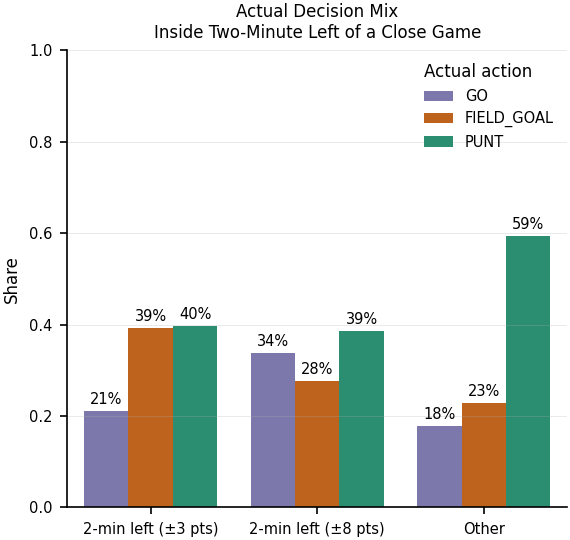

In [17]:
# Two-minute drill flag (per half)
nfl_4th["two_min_drill"] = (nfl_4th["half_seconds_remaining"] <= 120).astype("int8")

# Action shares by quarter and two-minute
late_behavior = (nfl_4th
                 .groupby(["qtr","two_min_drill"])["model_action"]
                 .value_counts(normalize=True)
                 .rename("share")
                 .reset_index())

display(late_behavior.head(20))


# =========================================================
# PLOT 3 — Actual Decision Mix inside Two-Minute Warning of a Close Game
# =========================================================
ctx = nfl_4th.copy()
ctx["two_minute"] = (ctx["half_seconds_remaining"] <= 120)
ctx["close_game"] = (ctx["score_differential"].abs() <= 3)
ctx["one_possession_game"] = (ctx["score_differential"].abs() <= 8)
ctx["context"] = np.where(ctx["two_minute"] & ctx["close_game"],
                          "2-min left (±3 pts)",
                          np.where(ctx["two_minute"] & ctx["one_possession_game"],
                                   "2-min left (±8 pts)",
                                   "Other"))

order_actions = ["GO", "FIELD_GOAL", "PUNT"]
palette_actions = {"GO": colors["go"], "FIELD_GOAL": colors["fg"], "PUNT": colors["punt"]}

# Proportions by context
prop_ctx = (ctx.groupby(["context","actual_action"], group_keys=False)
              .size()
              .groupby(level=0, group_keys=False)
              .apply(lambda s: s / s.sum())
              .rename("share")
              .reset_index())

fig, ax = plt.subplots(figsize=(WIDTH, WIDTH*0.95))
sns.barplot(
    data=prop_ctx, x="context", y="share", hue="actual_action",
    hue_order=order_actions, palette=palette_actions, ax=ax
)

# Axes & legend (minimalist)
ax.set_title("Actual Decision Mix\nInside Two-Minute Left of a Close Game", fontsize=8)
ax.set_xlabel("")
ax.set_ylabel("Share")
ax.set_ylim(0, 1)
leg = ax.legend(title="Actual action", frameon=False, loc="upper right")
if leg:
    try:
        # Align legend entries to the left (best-effort; seaborn/mpl internals can vary)
        leg._legend_box.align = "left"
    except Exception:
        pass

# Bar annotations (percents), small and tidy
for p in ax.patches:
    h = p.get_height()
    if h > 0.02:
        ax.annotate(f"{h*100:.0f}%",
                    (p.get_x() + p.get_width()/2, h),
                    ha="center", va="bottom",
                    fontsize=7, xytext=(0, 2),
                    textcoords="offset points")

fig.tight_layout()
if SAVE_FIGS:
    fig.savefig(os.path.join(SAVE_DIR, "decision_mix_2min.png"))
plt.show()


Early game (Q1–Q3, outside 2-min): model slightly prefers PUNT ≈ 41–46% over GO ≈ 39–40%, with FG ≈ 13–20%.

Q1 (non–2-min): PUNT 46.4%, GO 40.3%, FG 13.3%.

Q2 (non–2-min): PUNT 40.9%, GO 38.7%, FG 20.3%.

Q3 (non–2-min): PUNT 41.5%, GO 40.5%, FG 18.0%.

Halftime 2-minute (Q2, 2-min): the model shifts toward FG and away from GO:

Q2 (2-min): FG 31.5% (↑ ~+11 pts vs non–2-min), GO 30.0% (↓ ~−8.7 pts), PUNT 38.6% (slight ↓).

Interpretation: with limited time before halftime, taking the guaranteed scoring chance rises in value.

Late game (Q4, outside 2-min): aggression ramps up:

Q4 (non–2-min): GO 44.7% (highest outside 2-min), PUNT 34.3%, FG 21.0%.

Endgame (Q4, 2-min): big swing to GO:

Q4 (2-min): GO 65.0% (↑ ~+20 pts vs non–2-min), PUNT 16.2% (↓ ~−18 pts), FG 18.7% (−2.3 pts).

Interpretation: with the game on the line, the model prioritizes drive survival over field position or three points.

OT (qtr=5): model leans conservative but balanced:

PUNT 42.5%, GO 34.8%, FG ~22.7% (by remainder).

Overall agreement: 0.678


ytg_bin,1-2,3-5,6-10,11+
yardline_bin,,,,
RZ 0-20,0.660,0.585,0.790,0.914
20-40,0.679,0.556,0.691,0.785
40-60,0.571,0.395,0.570,0.835
60-80,0.279,0.527,0.810,0.925
80-100,0.173,0.499,0.818,0.935


wind,Calm,Light,Moderate,Windy,VeryWindy
temp,,,,,
Frigid,0.672,0.654,0.682,0.721,0.726
Cold,0.685,0.682,0.691,0.721,0.715
Cool,0.676,0.697,0.687,0.717,0.692
Mild,0.657,0.667,0.674,0.662,0.675
Warm/Hot,0.654,0.656,0.687,0.668,0.738


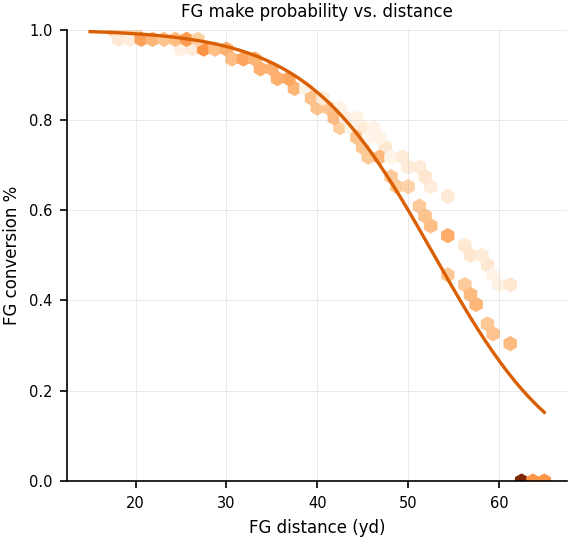

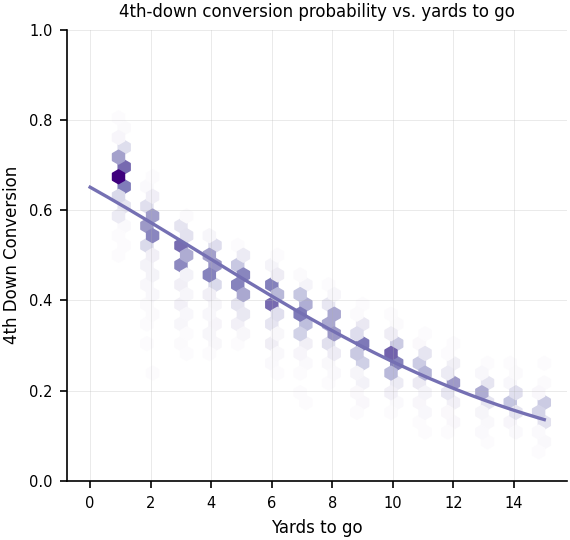

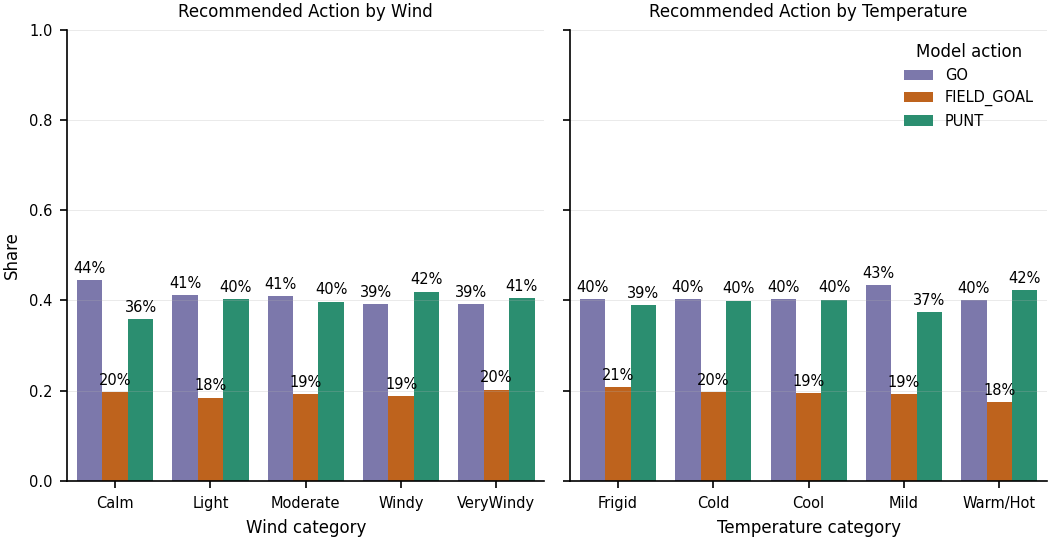

In [18]:
# Agreement flag
nfl_4th["agree"] = (nfl_4th["actual_action"] == nfl_4th["model_action"]).astype("int8")
print("Overall agreement:", nfl_4th["agree"].mean().round(3))

# Agreement by context (field position / ytg)
agree_table = (nfl_4th
               .groupby(["yardline_bin","ytg_bin"])["agree"]
               .mean()
               .unstack(1)
               .round(3))
display(agree_table)

# Agreement by environment
agree_env = (nfl_4th
             .groupby(["wind","temp"])["agree"]
             .mean()
             .unstack(0)
             .round(3))
display(agree_env)

# =========================================================
# PLOT 1 — FG make probability vs. distance (15–65 yd)
# =========================================================
df = nfl_4th.copy()
df["fg_dist_yd"] = (df["yardline_100"] + 17).clip(lower=0)
s = df.loc[:, ["fg_dist_yd", "fg_make_prob"]].dropna().copy()
s = s.query("fg_dist_yd >= 15 and fg_dist_yd <= 65").copy()

# GLM(logit) fit
eps = 1e-6
y_fg = s["fg_make_prob"].clip(eps, 1 - eps)
X_fg = sm.add_constant(s["fg_dist_yd"])
glm_fg = sm.GLM(y_fg, X_fg, family=sm.families.Binomial()).fit()

x_pred_fg = np.linspace(15, 65, 400)
y_pred_fg = glm_fg.predict(sm.add_constant(x_pred_fg))

fig, ax_fg = plt.subplots(figsize=(WIDTH, WIDTH*0.95))
ax_fg.hexbin(
    s["fg_dist_yd"], s["fg_make_prob"],
    gridsize=40, cmap="Oranges",
    extent=(15, 65, 0, 1), mincnt=1
)
ax_fg.plot(x_pred_fg, y_pred_fg, color=colors["fg"], lw=1.6)

ax_fg.set_title("FG make probability vs. distance", fontsize=8)
ax_fg.set_xlabel("FG distance (yd)")
ax_fg.set_ylabel("FG conversion %")
ax_fg.set_ylim(0, 1)

fig.tight_layout()
if SAVE_FIGS:
    fig.savefig(os.path.join(SAVE_DIR, "fg_prob_vs_distance.png"))
plt.show()

# =========================================================
# PLOT 2 — 4th-down conversion probability vs. yards to go (0–15)
# =========================================================
s = nfl_4th.loc[:, ["ydstogo", "first_down_prob"]].dropna().copy()
s = s.query("ydstogo >= 0 and ydstogo <= 15").copy()

# GLM(logit) fit
eps = 1e-6
y_go = s["first_down_prob"].clip(eps, 1 - eps)
X_go = sm.add_constant(s["ydstogo"])
glm_go = sm.GLM(y_go, X_go, family=sm.families.Binomial()).fit()

x_pred_go = np.linspace(0, 15, 400)
y_pred_go = glm_go.predict(sm.add_constant(x_pred_go))

fig, ax_go = plt.subplots(figsize=(WIDTH, WIDTH*0.95))
ax_go.hexbin(
    s["ydstogo"], s["first_down_prob"],
    gridsize=40, cmap="Purples",
    extent=(0, 15, 0, 1), mincnt=1
)
ax_go.plot(x_pred_go, y_pred_go, color=colors["go"], lw=1.6)

ax_go.set_title("4th-down conversion probability vs. yards to go", fontsize=8)
ax_go.set_xlabel("Yards to go")
ax_go.set_ylabel("4th Down Conversion")
ax_go.set_ylim(0, 1)

fig.tight_layout()
if SAVE_FIGS:
    fig.savefig(os.path.join(SAVE_DIR, "go_prob_vs_ytg.png"))
plt.show()

# =========================================================
# PLOT 3 — Recommended Action by Weather (Wind & Temperature)
# =========================================================
# Compute model_action if not present (argmax of available WPs)
def _pick_action(row):
    vals = {"GO": row.get("go_wp"), "FIELD_GOAL": row.get("fg_wp"), "PUNT": row.get("punt_wp")}
    vals = {k: v for k, v in vals.items() if pd.notna(v)}
    return max(vals, key=vals.get) if vals else np.nan

if "model_action" not in nfl_4th.columns:
    nfl_4th["model_action"] = nfl_4th.apply(_pick_action, axis=1)

# Expected category orders
wind_order = ["Calm", "Light", "Moderate", "Windy", "VeryWindy"]
temp_order = ["Frigid", "Cold", "Cool", "Mild", "Warm/Hot"]
act_order  = ["GO", "FIELD_GOAL", "PUNT"]

wind_share = (nfl_4th
              .groupby(["wind", "model_action"], group_keys=False)
              .size()
              .groupby(level=0, group_keys=False)
              .apply(lambda s: s / s.sum())
              .rename("share")
              .reset_index())
wind_share["wind"] = pd.Categorical(wind_share["wind"], categories=wind_order, ordered=True)

temp_share = (nfl_4th
              .groupby(["temp", "model_action"], group_keys=False)
              .size()
              .groupby(level=0, group_keys=False)
              .apply(lambda s: s / s.sum())
              .rename("share")
              .reset_index())
temp_share["temp"] = pd.Categorical(temp_share["temp"], categories=temp_order, ordered=True)

fig, axes = plt.subplots(1, 2, figsize=(WIDTH*1.8, WIDTH*0.95), sharey=True)

sns.barplot(
    data=wind_share, x="wind", y="share", hue="model_action",
    hue_order=act_order, palette=palette_actions, ax=axes[0]
)
axes[0].set_title("Recommended Action by Wind", fontsize=8)
axes[0].set_xlabel("Wind category")
axes[0].set_ylabel("Share")
axes[0].set_ylim(0, 1)
axes[0].legend_.remove()

sns.barplot(
    data=temp_share, x="temp", y="share", hue="model_action",
    hue_order=act_order, palette=palette_actions, ax=axes[1]
)
axes[1].set_title("Recommended Action by Temperature", fontsize=8)
axes[1].set_xlabel("Temperature category")
axes[1].set_ylabel("")
axes[1].set_ylim(0, 1)
axes[1].legend(title="Model action", loc="upper right", frameon=False)

# annotate bars
for ax in axes:
    for p in ax.patches:
        h = p.get_height()
        if h > 0.03:
            ax.annotate(f"{h*100:.0f}%",
                        (p.get_x() + p.get_width()/2, h),
                        ha="center", va="bottom", fontsize=7,
                        xytext=(0, 2), textcoords="offset points")

fig.tight_layout()
if 'SAVE_FIGS' in globals() and SAVE_FIGS:
    fig.savefig(os.path.join(SAVE_DIR, "recommended_action_by_weather.png"))
plt.show()


Field position × YTG (agreement)

Obvious spots = high agreement.

Red zone, long YTG (11+) → 0.914 (FG for both).

Own territory, long YTG (60–100 & 11+) → 0.925–0.935 (PUNT for both).

Own territory, 6–10 → 0.810–0.818 (mostly PUNT).

Short yardage outside the red zone = big disagreement.

60–80, 1–2 → 0.279 and 80–100, 1–2 → 0.173 (coaches punt a lot; model wants GO).

Midfield 40–60, 3–5 → 0.395 (borderline; model more aggressive).

Red zone, 1–2 has only moderate agreement (0.660) → coaches kick FGs more than the model would in prime GO situations.

Takeaway: disagreement concentrates in short YTG when you’re not yet in the red zone. Everywhere else, choices are pretty aligned.

Environment (temp × wind → agreement)

Agreement is remarkably flat by weather: mostly 0.65–0.73 across cells.

No systematic pattern big enough to rival field position/YTG effects.

Takeaway: for agreement, weather ≪ situation. (Weather still matters for which action is best in certain slices, but it doesn’t drive coach–model gaps nearly as much.)

In [19]:
summary = {}

summary["n_plays"] = len(nfl_4th)
summary["action_counts"] = nfl_4th["actual_action"].value_counts().to_dict()
summary["overall_agreement"] = round(nfl_4th["agree"].mean(), 3)

# Where model says FG most often
fg_by_dist = (nfl_4th.groupby("fg_dist_bin")["model_action"]
              .apply(lambda s: (s=="FIELD_GOAL").mean()))
summary["fg_peak_bin"] = fg_by_dist.idxmax()
summary["fg_peak_share"] = round(fg_by_dist.max(), 3)

# Where decisions are closest
summary["closest_bins"] = (nfl_4th.groupby(["yardline_bin","ytg_bin"])["margin_top2"]
                           .mean().sort_values().head(5))

for k, v in summary.items():
    print(f"{k}: {v}")


n_plays: 40655
action_counts: {'PUNT': 23455, 'FIELD_GOAL': 9609, 'GO': 7591}
overall_agreement: 0.678
fg_peak_bin: 30-34
fg_peak_share: 0.703
closest_bins: yardline_bin  ytg_bin
80-100        3-5        0.007977
60-80         3-5        0.009679
40-60         6-10       0.011339
              3-5        0.014408
20-40         3-5        0.014932
Name: margin_top2, dtype: float64


Scale & class mix. 40,655 fourth‐down plays: PUNT 57.7%, FG 23.7%, GO 18.7% → strong class imbalance toward punts (use class-aware metrics later).

Coach–model alignment. Overall agreement = 0.678. That’s decent but leaves meaningful room for improvement—good for a “coach’s agreement” KPI.

Where the model likes FGs most. Peak FG recommendation is at 30–34 yds (estimated distance), with FG share = 0.703. This is your “automatic FG” zone for the policy narrative.

True gray zones (smallest WP margin between top-1 and top-2 actions).
The tightest decisions (margin ≈ 0.008–0.015) cluster in:

Own territory, 3–5 yds to go: 80–100 and 60–80 bins

Midfield, 3–5 yds and 6–10 yds: 40–60 bin

Opp side but not red zone, 3–5 yds: 20–40 bin
Translation: the 3–5 yds band is the universal knife-edge, with midfield 6–10 also borderline. Great places to surface uncertainty in the UI (“coin-flip” badges, show margin).

Storyline to use. “The model partitions the field cleanly (short-yardage → GO; red-zone long yardage → FG; deep/long → PUNT), but short-yardage outside the red zone creates consistent borderline trade-offs between aggression and field position.”

### Variables objetivo

In [20]:
# Consistent action palette from prior cell
palette_actions = {"GO": colors["go"], "FIELD_GOAL": colors["fg"], "PUNT": colors["punt"]}
act_order = ["GO","FIELD_GOAL","PUNT"]

df = nfl_4th.copy()

# Availability flags (punt_wp is NA when punt not viable in nfl4th)
df["avail_go"] = np.isfinite(df["go_wp"])
df["avail_fg"] = np.isfinite(df["fg_wp"])
df["avail_punt"] = np.isfinite(df["punt_wp"])

# Estimated FG distance
df["fg_dist_yd"] = (df["yardline_100"] + 17).clip(lower=0)

# Model policy targets from nfl4th outputs (teacher)
wp_cols = ["go_wp", "fg_wp", "punt_wp"]
_wp = df[wp_cols].copy().where(np.isfinite(df[wp_cols]), -np.inf)

# y_opt_action (argmax of WPs over available actions)
opt_idx = _wp.to_numpy().argmax(axis=1)
df["y_opt_action"] = np.take(["go_wp", "fg_wp", "punt_wp"], opt_idx)
df["y_opt_action"] = df["y_opt_action"].map({"go_wp":"GO","fg_wp":"FIELD_GOAL","punt_wp":"PUNT"})

# y_confidence = top1 - top2 among available actions
sorted_wp = np.sort(_wp.to_numpy(), axis=1)
df["y_confidence"] = (sorted_wp[:, -1] - sorted_wp[:, -2]).astype(float)

# actual_action from cleaned label
df["actual_action"] = pd.Categorical(df["play_type_nfl"], categories=act_order)

# y_wp_regret = best(WP) - WP(actual_action)
def _wp_of_action_row(row):
    if row["actual_action"] == "GO":
        return row["go_wp"]
    if row["actual_action"] == "FIELD_GOAL":
        return row["fg_wp"]
    if row["actual_action"] == "PUNT":
        return row["punt_wp"]
    return np.nan

df["wp_actual"] = df.apply(_wp_of_action_row, axis=1)
df["wp_best"] = _wp.max(axis=1)
df["y_wp_regret"] = (df["wp_best"] - df["wp_actual"]).astype(float)

# Binning for field position / yards-to-go
def _ytg_bin(y):
    if y <= 2: return "1-2"
    if y <= 5: return "3-5"
    if y <= 10: return "6-10"
    return "11+"

def _yard_bin(yl):
    if yl <= 20:  return "RZ 0-20"
    if yl <= 40:  return "20-40"
    if yl <= 60:  return "40-60"
    if yl <= 80:  return "60-80"
    return "80-100"

ytg_order = ["1-2","3-5","6-10","11+"]
yard_order = ["RZ 0-20","20-40","40-60","60-80","80-100"]

df["ytg_bin"] = pd.Categorical(df["ydstogo"].apply(_ytg_bin), categories=ytg_order, ordered=True)
df["yardline_bin"] = pd.Categorical(df["yardline_100"].apply(_yard_bin), categories=yard_order, ordered=True)
df["y_opt_action"] = pd.Categorical(df["y_opt_action"], categories=act_order)

# Two-minute drill flag (Q2/Q4 with <= 120s)
df["two_min_drill"] = np.where(df["qtr"].isin([2,4]) & (df["quarter_seconds_remaining"] <= 120), 1, 0)

# Distance bins for FG share plot
bins = [0,30,35,40,45,50,55,60,120]
labels = ["<30","30-34","35-39","40-44","45-49","50-54","55-59","60+"]
df["fg_dist_bin"] = pd.cut(df["fg_dist_yd"], bins=bins, labels=labels, include_lowest=True, right=False)

# Ensure save dir
if 'SAVE_FIGS' in globals() and SAVE_FIGS:
    os.makedirs(SAVE_DIR, exist_ok=True)

#### - Relación de features con variables objetivo

/var/folders/lm/z70n500n5yz1798_6ckkxp300000gn/T/ipykernel_73009/306221832.py:149: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  grp = (focus
/var/folders/lm/z70n500n5yz1798_6ckkxp300000gn/T/ipykernel_73009/306221832.py:215: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df.groupby(["yard_bin5","

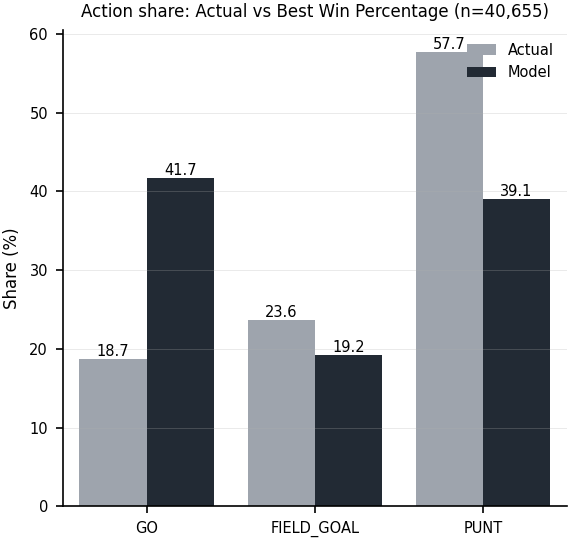

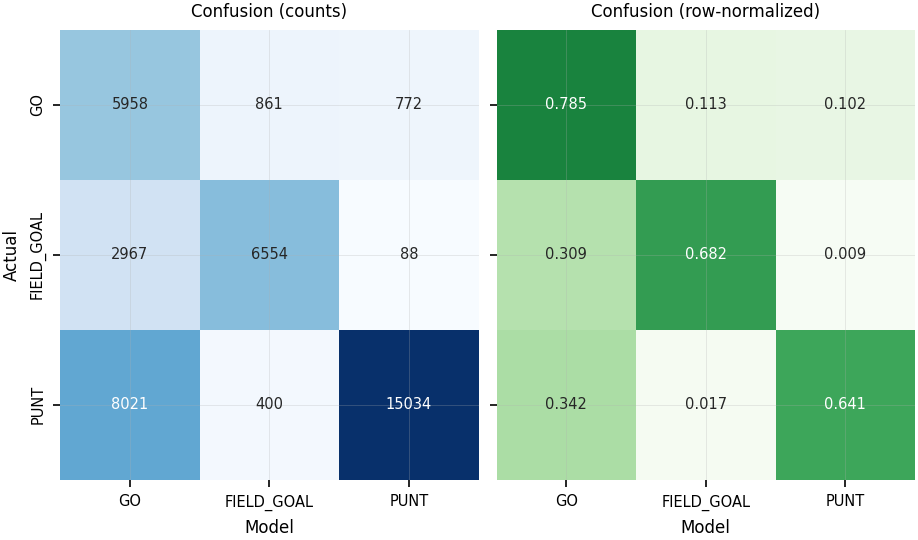

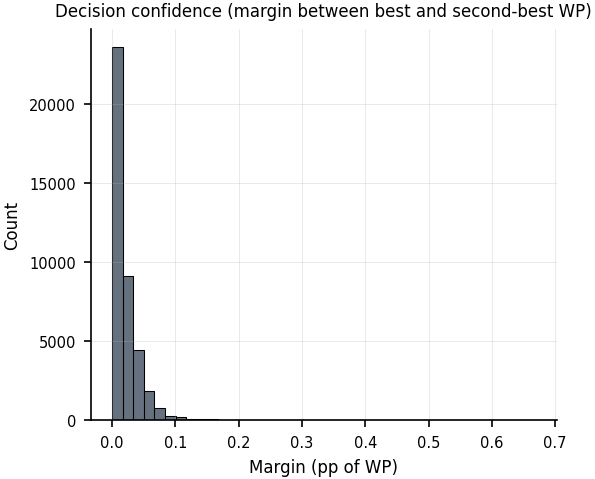

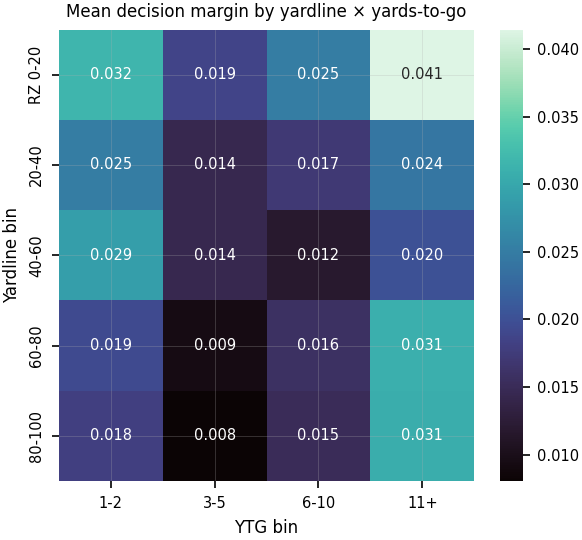

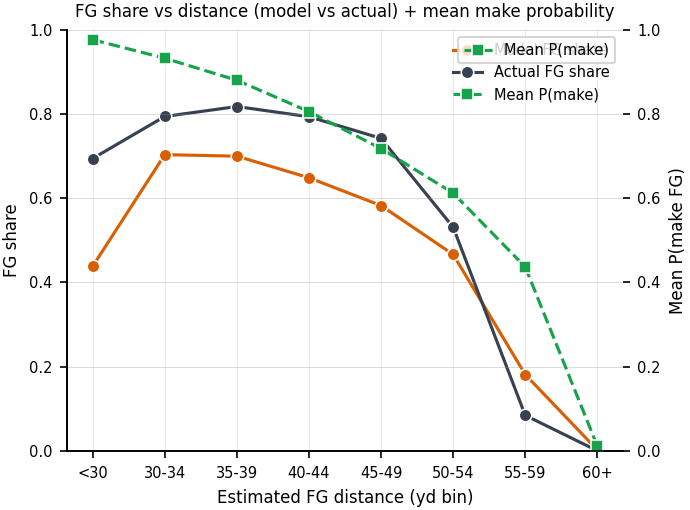

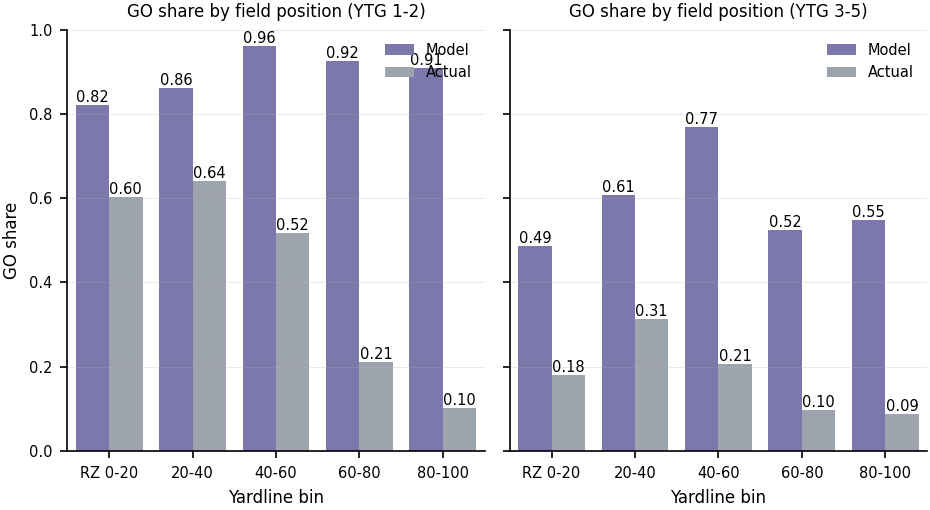

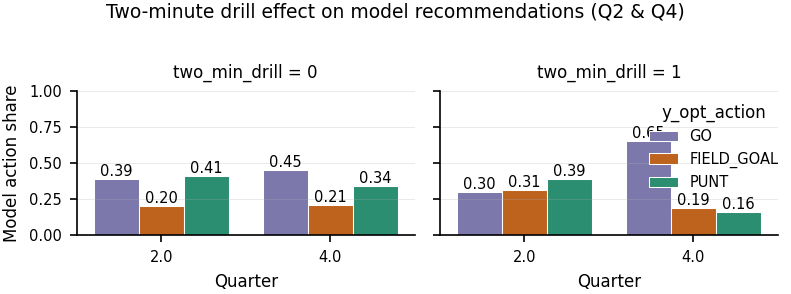

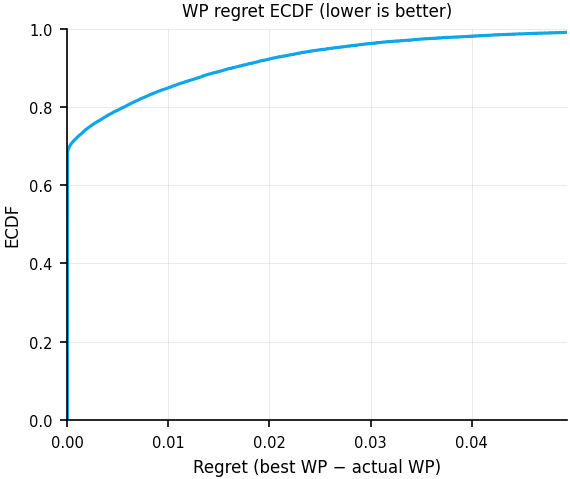

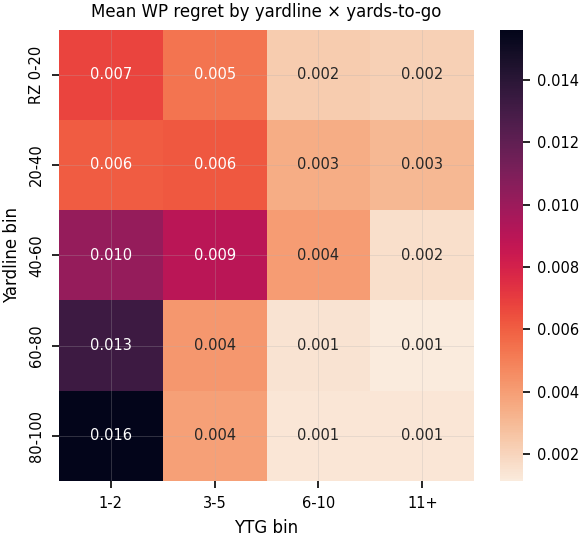

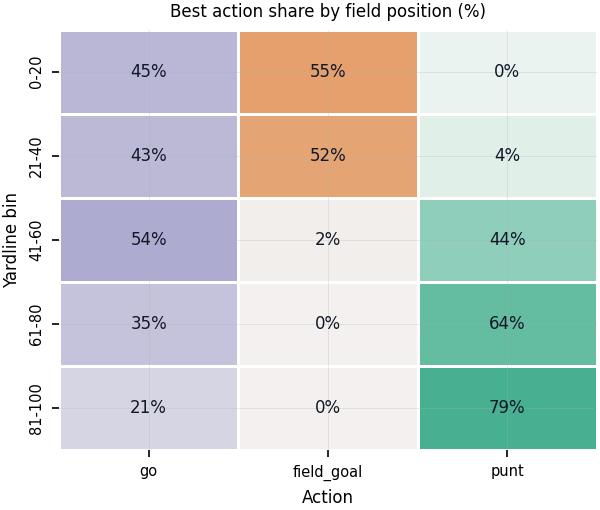

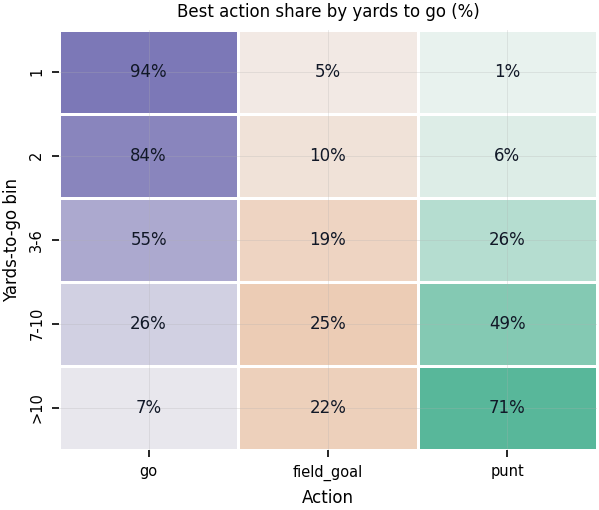

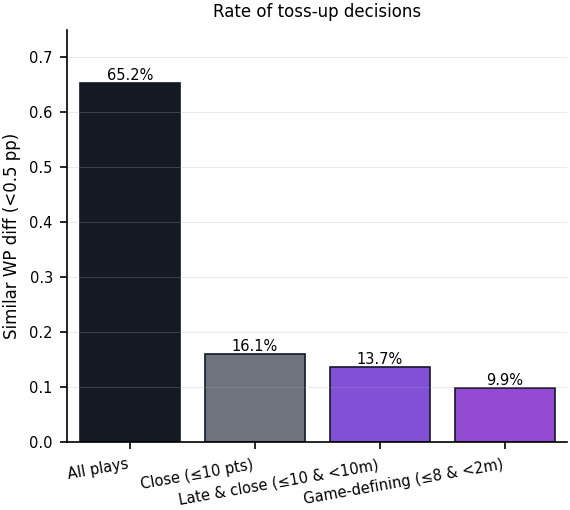

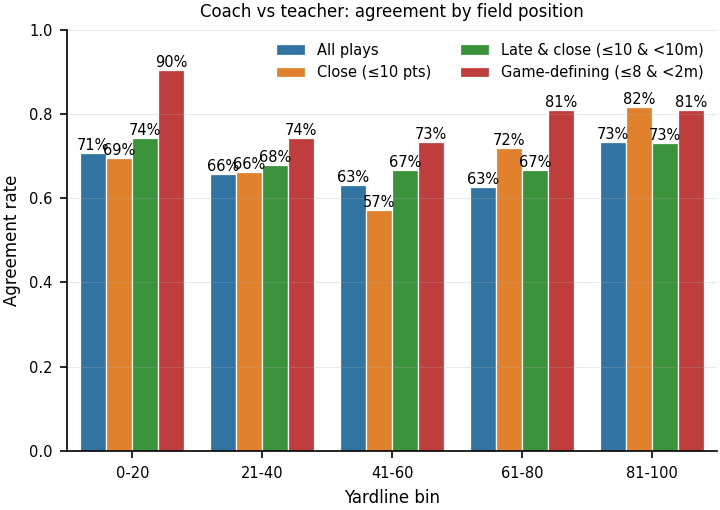

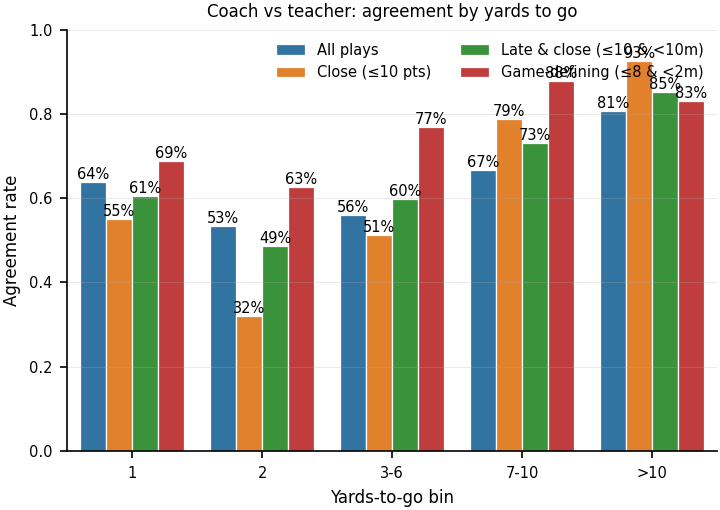

In [21]:
# =========================================================
# PLOT 1 — Action share: Actual vs Model
# =========================================================
share = (
    pd.concat([
        df["actual_action"].value_counts(normalize=True).rename("Actual"),
        df["y_opt_action"].value_counts(normalize=True).rename("Model")
    ], axis=1)
    .loc[act_order]
    .mul(100)
    .reset_index(names="Action")
    .melt(id_vars="Action", var_name="Source", value_name="Share (%)")
)

fig, ax = plt.subplots(figsize=(WIDTH, WIDTH*0.95))
sns.barplot(data=share, x="Action", y="Share (%)", hue="Source",
            palette=["#9ca3af","#1f2937"], ax=ax)
for c in ax.containers:
    ax.bar_label(c, fmt="%.1f", fontsize=7)
ax.set_title(f"Action share: Actual vs Best Win Percentage (n={len(df):,})", fontsize=8)
ax.set_xlabel(""); ax.set_ylabel("Share (%)")
ax.legend(frameon=False, loc="upper right")
fig.tight_layout()
if 'SAVE_FIGS' in globals() and SAVE_FIGS:
    fig.savefig(os.path.join(SAVE_DIR, "eda_action_share_actual_vs_model.png"))


# =========================================================
# PLOT 2 — Confusion (counts & row-normalized)
# =========================================================
cm = pd.crosstab(df["actual_action"], df["y_opt_action"]).reindex(index=act_order, columns=act_order)
cm_norm = cm.div(cm.sum(axis=1), axis=0)

fig, axes = plt.subplots(1, 2, figsize=(WIDTH*1.58, WIDTH*0.95), sharey=True)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0],
            annot_kws={"fontsize":7})
axes[0].set_title("Confusion (counts)", fontsize=8)
axes[0].set_xlabel("Model"); axes[0].set_ylabel("Actual")

sns.heatmap(cm_norm, annot=True, fmt=".3f", cmap="Greens", vmin=0, vmax=1, cbar=False, ax=axes[1],
            annot_kws={"fontsize":7})
axes[1].set_title("Confusion (row-normalized)", fontsize=8)
axes[1].set_xlabel("Model"); axes[1].set_ylabel("")
fig.tight_layout()
if 'SAVE_FIGS' in globals() and SAVE_FIGS:
    fig.savefig(os.path.join(SAVE_DIR, "eda_confusion_actual_vs_model.png"))


# =========================================================
# PLOT 3 — Decision confidence (margin between best and second-best WP)
# =========================================================
fig, ax = plt.subplots(figsize=(WIDTH, WIDTH*0.85))
sns.histplot(df["y_confidence"], bins=40, kde=False, color="#334155", ax=ax)
ax.set_title("Decision confidence (margin between best and second-best WP)", fontsize=8)
ax.set_xlabel("Margin (pp of WP)"); ax.set_ylabel("Count")
fig.tight_layout()
if 'SAVE_FIGS' in globals() and SAVE_FIGS:
    fig.savefig(os.path.join(SAVE_DIR, "eda_margin_hist.png"))


# =========================================================
# PLOT 4 — Mean decision margin by yardline × yards-to-go
# =========================================================
heat = (df.groupby(["yardline_bin","ytg_bin"], observed=True)["y_confidence"]
          .mean().reset_index())
pivot = heat.pivot(index="yardline_bin", columns="ytg_bin", values="y_confidence").loc[yard_order, ytg_order]

fig, ax = plt.subplots(figsize=(WIDTH*1.03, WIDTH*0.95))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap="mako", ax=ax,
            annot_kws={"fontsize":7})
ax.set_title("Mean decision margin by yardline × yards-to-go", fontsize=8)
ax.set_xlabel("YTG bin"); ax.set_ylabel("Yardline bin")
fig.tight_layout()
if 'SAVE_FIGS' in globals() and SAVE_FIGS:
    fig.savefig(os.path.join(SAVE_DIR, "eda_margin_heatmap_bins.png"))


# =========================================================
# PLOT 5 — FG share vs distance (model vs actual) + mean P(make)
# =========================================================
agg = (
    df.groupby("fg_dist_bin", observed=True)
      .agg(fg_model_share=("y_opt_action", lambda s: (s=="FIELD_GOAL").mean()),
           fg_actual_share=("actual_action", lambda s: (s=="FIELD_GOAL").mean()),
           fg_make_prob_avg=("fg_make_prob","mean"))
      .reset_index()
      .dropna(subset=["fg_dist_bin"])
)

fig, ax1 = plt.subplots(figsize=(WIDTH*1.2, WIDTH*0.9))
sns.lineplot(data=agg, x="fg_dist_bin", y="fg_model_share", marker="o",
             label="Model FG share", color=colors["fg"], ax=ax1)
sns.lineplot(data=agg, x="fg_dist_bin", y="fg_actual_share", marker="o",
             label="Actual FG share", color="#374151", ax=ax1)
ax1.set_ylabel("FG share"); ax1.set_xlabel("Estimated FG distance (yd bin)")
ax1.set_ylim(0, 1)

ax2 = ax1.twinx()
sns.lineplot(data=agg, x="fg_dist_bin", y="fg_make_prob_avg", marker="s",
             linestyle="--", label="Mean P(make)", color="#16a34a", ax=ax2)
ax2.set_ylabel("Mean P(make FG)"); ax2.set_ylim(0, 1)

# merge legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1+lines2, labels1+labels2, frameon=False, loc="upper right")
ax1.set_title("FG share vs distance (model vs actual) + mean make probability", fontsize=8)
fig.tight_layout()
if 'SAVE_FIGS' in globals() and SAVE_FIGS:
    fig.savefig(os.path.join(SAVE_DIR, "eda_fg_share_vs_distance.png"))


# =========================================================
# PLOT 6 — GO share by field position (short yardage: 1–2, 3–5)
# =========================================================
short = df[df["ytg_bin"].isin(["1-2","3-5"])].copy()
go_share = (
    short.groupby(["ytg_bin","yardline_bin"], observed=True)
         .agg(model_go=("y_opt_action", lambda s: (s=="GO").mean()),
              actual_go=("actual_action", lambda s: (s=="GO").mean()))
         .reset_index()
)

fig, axes = plt.subplots(1, 2, figsize=(WIDTH*1.6, WIDTH*0.9), sharey=True)
for i, ytg in enumerate(["1-2","3-5"]):
    sub = (go_share[go_share["ytg_bin"]==ytg]
           .set_index("yardline_bin").loc[yard_order].reset_index())
    sub_m = sub.melt(id_vars="yardline_bin", value_vars=["model_go","actual_go"],
                     var_name="Source", value_name="GO share")
    sub_m["Source"] = sub_m["Source"].map({"model_go":"Model","actual_go":"Actual"})

    sns.barplot(data=sub_m, x="yardline_bin", y="GO share", hue="Source",
                palette=[palette_actions["GO"], "#9ca3af"], ax=axes[i])
    axes[i].set_title(f"GO share by field position (YTG {ytg})", fontsize=8)
    axes[i].set_xlabel("Yardline bin"); axes[i].set_ylabel("GO share")
    axes[i].set_ylim(0,1); axes[i].legend(frameon=False, loc="upper right")
    for c in axes[i].containers:
        axes[i].bar_label(c, fmt="%.2f", fontsize=7)

fig.tight_layout()
if 'SAVE_FIGS' in globals() and SAVE_FIGS:
    fig.savefig(os.path.join(SAVE_DIR, "eda_go_share_short_yardage.png"))


# =========================================================
# PLOT 7 — Two-minute drill effect on model recommendations (Q2 & Q4)
# =========================================================
focus = df[df["qtr"].isin([2,4])].copy()
grp = (focus
       .groupby(["qtr","two_min_drill","y_opt_action"], observed=True)
       .size()
       .groupby(level=[0,1]).apply(lambda s: s / s.sum())
       .reset_index(name="share"))

g = sns.catplot(
    data=grp, x="qtr", y="share", hue="y_opt_action", col="two_min_drill",
    kind="bar", palette=palette_actions, hue_order=act_order,
    height=WIDTH*0.5, aspect=1.1, edgecolor="white", linewidth=0.5
)
g.set_axis_labels("Quarter", "Model action share")
g.set_titles("two_min_drill = {col_name}")
for ax in g.axes.flat:
    ax.set_ylim(0,1)
    for c in ax.containers:
        ax.bar_label(c, fmt="%.2f", fontsize=7)
g.fig.suptitle("Two-minute drill effect on model recommendations (Q2 & Q4)", y=1.02, fontsize=9)
g.fig.tight_layout()
if 'SAVE_FIGS' in globals() and SAVE_FIGS:
    g.fig.savefig(os.path.join(SAVE_DIR, "eda_two_minute_model_action.png"))


# =========================================================
# PLOT 8 — WP regret ECDF (lower is better)
# =========================================================
reg = df[np.isfinite(df["y_wp_regret"])].copy()

fig, ax = plt.subplots(figsize=(WIDTH, WIDTH*0.85))
sns.ecdfplot(reg["y_wp_regret"], ax=ax, color="#0ea5e9")
ax.set_xlim(0, reg["y_wp_regret"].quantile(0.99))
ax.set_title("WP regret ECDF (lower is better)", fontsize=8)
ax.set_xlabel("Regret (best WP − actual WP)"); ax.set_ylabel("ECDF")
fig.tight_layout()
if 'SAVE_FIGS' in globals() and SAVE_FIGS:
    fig.savefig(os.path.join(SAVE_DIR, "eda_regret_ecdf.png"))


# =========================================================
# PLOT 9 — Mean WP regret by yardline × yards-to-go
# =========================================================
heat_r = (reg.groupby(["yardline_bin","ytg_bin"], observed=True)["y_wp_regret"]
            .mean().reset_index())
pivot_r = heat_r.pivot(index="yardline_bin", columns="ytg_bin",
                       values="y_wp_regret").loc[yard_order, ytg_order]

fig, ax = plt.subplots(figsize=(WIDTH*1.03, WIDTH*0.95))
sns.heatmap(pivot_r, annot=True, fmt=".3f", cmap="rocket_r", ax=ax,
            annot_kws={"fontsize":7})
ax.set_title("Mean WP regret by yardline × yards-to-go", fontsize=8)
ax.set_xlabel("YTG bin"); ax.set_ylabel("Yardline bin")
fig.tight_layout()
if 'SAVE_FIGS' in globals() and SAVE_FIGS:
    fig.savefig(os.path.join(SAVE_DIR, "eda_regret_heatmap_bins.png"))


# =========================================================
# PLOT 10 — Best action share by field position (%), overlay heatmaps
# =========================================================
# Yardline bins to 5 groups
bins_yard = [-0.1, 20, 40, 60, 80, 100]
labels_yard5 = ["0-20","21-40","41-60","61-80","81-100"]
df["yard_bin5"] = pd.cut(df["yardline_100"], bins=bins_yard, labels=labels_yard5,
                         right=True, include_lowest=True)

share_yard = (
    df.groupby(["yard_bin5","y_opt_action"]).size()
      .groupby(level=0).apply(lambda s: s / s.sum())
      .unstack(fill_value=0)
      .reindex(columns=act_order)
      .reindex(labels_yard5)
)

fig, ax = plt.subplots(figsize=(WIDTH*1.05, WIDTH*0.9))
data = share_yard.to_numpy()

cmaps = {
    "GO": sns.light_palette(colors["go"], as_cmap=True),
    "FIELD_GOAL": sns.light_palette(colors["fg"], as_cmap=True),
    "PUNT": sns.light_palette(colors["punt"], as_cmap=True),
}

for j, act in enumerate(act_order):
    mask = np.ones_like(data, dtype=bool); mask[:, j] = False
    labels_mat = np.full_like(data, "", dtype=object)
    labels_mat[:, j] = [f"{int(round(v*100))}%" for v in data[:, j]]
    sns.heatmap(
        data, mask=mask, cmap=cmaps[act], vmin=0, vmax=1, cbar=False, ax=ax,
        annot=labels_mat, fmt="", annot_kws={"fontsize":8, "color":"#111827"},
        xticklabels=[a.lower() for a in act_order], yticklabels=labels_yard5,
        linewidths=0.5, linecolor="white"
    )

ax.set_xlabel("Action"); ax.set_ylabel("Yardline bin")
ax.set_title("Best action share by field position (%)", fontsize=8)
fig.tight_layout()
if 'SAVE_FIGS' in globals() and SAVE_FIGS:
    fig.savefig(os.path.join(SAVE_DIR, "eda_best_action_share_by_field.png"))


# =========================================================
# PLOT 11 — Best action share by yards to go (%), overlay heatmaps
# =========================================================
def _ytg_bin5(v):
    if v <= 1:   return "1"
    if v == 2:   return "2"
    if v <= 6:   return "3-6"
    if v <= 10:  return "7-10"
    return ">10"

df2 = df.copy()
df2["ytg_bin5"] = df2["ydstogo"].apply(_ytg_bin5)
ytg_order5 = ["1","2","3-6","7-10",">10"]

share_ytg = (
    df2.groupby(["ytg_bin5","y_opt_action"]).size()
       .groupby(level=0).apply(lambda s: s / s.sum())
       .unstack(fill_value=0)
       .reindex(columns=act_order)
       .reindex(ytg_order5)
)

fig, ax = plt.subplots(figsize=(WIDTH*1.05, WIDTH*0.9))
data = share_ytg.to_numpy()

for j, act in enumerate(act_order):
    mask = np.ones_like(data, dtype=bool); mask[:, j] = False
    labels_mat = np.full_like(data, "", dtype=object)
    labels_mat[:, j] = [f"{int(round(v*100))}%" for v in data[:, j]]
    sns.heatmap(
        data, mask=mask, cmap=cmaps[act], vmin=0, vmax=1, cbar=False, ax=ax,
        annot=labels_mat, fmt="", annot_kws={"fontsize":8, "color":"#111827"},
        xticklabels=[a.lower() for a in act_order], yticklabels=ytg_order5,
        linewidths=0.5, linecolor="white"
    )

ax.set_xlabel("Action"); ax.set_ylabel("Yards-to-go bin")
ax.set_title("Best action share by yards to go (%)", fontsize=8)
fig.tight_layout()
if 'SAVE_FIGS' in globals() and SAVE_FIGS:
    fig.savefig(os.path.join(SAVE_DIR, "eda_best_action_share_by_ytg.png"))


# =========================================================
# PLOT 12 — Toss-up rate & Coach vs Teacher agreement (by bins)
# =========================================================
# Scenario tags
ABS_DIFF = df["score_differential"].abs()
GS = df["game_seconds_remaining"]
df["scenario"] = "All plays"
df.loc[(ABS_DIFF <= 10), "scenario"] = "Close (≤10 pts)"
df.loc[(ABS_DIFF <= 10) & (GS < 600), "scenario"] = "Late & close (≤10 & <10m)"
df.loc[(ABS_DIFF <= 8) & (GS < 120), "scenario"] = "Game-defining (≤8 & <2m)"
scen_order = ["All plays","Close (≤10 pts)","Late & close (≤10 & <10m)","Game-defining (≤8 & <2m)"]
df["scenario"] = pd.Categorical(df["scenario"], categories=scen_order, ordered=True)

# Toss-up threshold
TOSSUP_PCT = 0.005  # 0.5 percentage points in WP
toss = (df.groupby("scenario")["y_confidence"]
          .apply(lambda s: (s < TOSSUP_PCT).mean())
          .reset_index(name="toss_rate"))

fig, ax = plt.subplots(figsize=(WIDTH, WIDTH*0.9))
sns.barplot(data=toss, x="scenario", y="toss_rate",
            palette=["#111827","#6b7280","#7c3aed","#9333ea"], ax=ax,
            edgecolor="#111827", linewidth=0.8)
ax.set_ylabel(f"Similar WP diff (<{TOSSUP_PCT*100:.1f} pp)"); ax.set_xlabel("")
ax.set_title("Rate of toss-up decisions", fontsize=8)
ax.set_ylim(0, max(0.01, toss["toss_rate"].max()*1.15))
ax.set_xticklabels(ax.get_xticklabels(), rotation=10, ha="right")
for c in ax.containers:
    ax.bar_label(c, labels=[f"{v:.1%}" for v in c.datavalues], fontsize=7)
fig.tight_layout()
if 'SAVE_FIGS' in globals() and SAVE_FIGS:
    fig.savefig(os.path.join(SAVE_DIR, "eda_tossup_rate.png"))

# Agreement
df["agree"] = (df["actual_action"] == df["y_opt_action"]).astype(int)

ytg_order5 = ["1","2","3-6","7-10",">10"]
df["ytg_bin5"] = pd.Categorical(df["ydstogo"].apply(_ytg_bin5), categories=ytg_order5, ordered=True)

agree_yard = (
    df.groupby(["scenario","yard_bin5"], observed=True)["agree"].mean()
      .reset_index().rename(columns={"agree":"agreement"})
)

fig, ax = plt.subplots(figsize=(WIDTH*1.25, WIDTH*0.9))
sns.barplot(data=agree_yard, x="yard_bin5", y="agreement", hue="scenario",
            hue_order=scen_order, ax=ax, edgecolor="white", linewidth=0.6)
ax.set_xlabel("Yardline bin"); ax.set_ylabel("Agreement rate")
ax.set_ylim(0,1); ax.set_title("Coach vs teacher: agreement by field position", fontsize=8)
for c in ax.containers:
    ax.bar_label(c, labels=[f"{v:.0%}" for v in c.datavalues], fontsize=7)
ax.legend(frameon=False, ncol=2, loc="upper right")
fig.tight_layout()
if 'SAVE_FIGS' in globals() and SAVE_FIGS:
    fig.savefig(os.path.join(SAVE_DIR, "eda_agreement_by_field.png"))

agree_ytg = (
    df.groupby(["scenario","ytg_bin5"], observed=True)["agree"].mean()
      .reset_index().rename(columns={"agree":"agreement"})
)

fig, ax = plt.subplots(figsize=(WIDTH*1.25, WIDTH*0.9))
sns.barplot(data=agree_ytg, x="ytg_bin5", y="agreement", hue="scenario",
            hue_order=scen_order, ax=ax, edgecolor="white", linewidth=0.6)
ax.set_xlabel("Yards-to-go bin"); ax.set_ylabel("Agreement rate")
ax.set_ylim(0,1); ax.set_title("Coach vs teacher: agreement by yards to go", fontsize=8)
for c in ax.containers:
    ax.bar_label(c, labels=[f"{v:.0%}" for v in c.datavalues], fontsize=7)
ax.legend(frameon=False, ncol=2, loc="upper right")
fig.tight_layout()
if 'SAVE_FIGS' in globals() and SAVE_FIGS:
    fig.savefig(os.path.join(SAVE_DIR, "eda_agreement_by_ytg.png"))


## 04 Entrenamiento de los modelos

### a) Modelo de Regresión de Probabilidad de Victoria (GO, FG, PUNT)

#### - Data Prep

In [22]:
# === MODEL 1 / CELL 1: DATA PREP =============================================
# Goal: build situational features + a lean frame for multi-task WP regression.
# Split strategy: Grouped by game_id to avoid leakage across the train/val split.

import os, json, warnings
import numpy as np
import pandas as pd

from sklearn.model_selection import GroupShuffleSplit

# Repro
SEED = 42
np.random.seed(SEED)

# ---- 1) Situational flags (purely from game state; idempotent) --------------
nfl_4th["is_fg_range"] = np.where(nfl_4th["yardline_100"] + 17 <= 67, 1, 0)
nfl_4th["fg_puts_ties_or_leads"] = np.where(nfl_4th["score_differential"].between(-3, 0), 1, 0)
nfl_4th["is_game_deciding"] = np.where(
    (nfl_4th["score_differential"].abs() <= 8) &
    (nfl_4th["game_seconds_remaining"] <= 120) &
    (nfl_4th["qtr"] == 4), 1, 0
)
nfl_4th["is_losing_by_one_score"] = np.where(
    (nfl_4th["score_differential"] < 0) & (nfl_4th["score_differential"] >= -8), 1, 0
)

# ---- 2) Feature lists --------------------------------------------------------
NUMERIC_FEATURES = [
    "yardline_100", "ydstogo", "qtr", "game_seconds_remaining",
    "score_differential", "posteam_timeouts_remaining", "defteam_timeouts_remaining",
    "two_minute_drill", "is_fg_range", "fg_puts_ties_or_leads",
    "is_game_deciding", "is_losing_by_one_score",
]
CATEGORICAL_FEATURES = ["roof", "surface", "temp", "wind"]
TARGET_COLS = ["go_wp", "fg_wp", "punt_wp"]

# ---- 3) Assemble frame (keep game_id for grouped split) ---------------------
cols_needed = ["game_id"] + NUMERIC_FEATURES + CATEGORICAL_FEATURES + TARGET_COLS
dfm = nfl_4th[cols_needed].copy()

# PUNT WP not viable -> set to 0.0 (teacher defines "unavailable" punts)
dfm["punt_wp"] = dfm["punt_wp"].fillna(0.0)

# Coerce categoricals to object for robust OHE
for c in CATEGORICAL_FEATURES:
    dfm[c] = dfm[c].astype("object")

display(dfm.head())
print(f"Shape: {dfm.shape}")
print("Missing values:\n", dfm.isna().sum())


,game_id,yardline_100,ydstogo,qtr,game_seconds_remaining,score_differential,posteam_timeouts_remaining,defteam_timeouts_remaining,two_minute_drill,is_fg_range,fg_puts_ties_or_leads,is_game_deciding,is_losing_by_one_score,roof,surface,temp,wind,go_wp,fg_wp,punt_wp
0,2014_01_BUF_CHI,76.0,6.0,1.0,3519.0,0.0,3,3,0,0,1,0,0,open_air,natural,Mild,Light,0.205945,0.155812,0.217337
1,2014_01_BUF_CHI,65.0,17.0,1.0,2935.0,0.0,3,3,0,0,1,0,0,open_air,natural,Mild,Light,0.694638,0.654108,0.733610
2,2014_01_BUF_CHI,44.0,4.0,2.0,2700.0,0.0,3,3,0,1,1,0,0,open_air,natural,Mild,Light,0.303086,0.278493,0.282596
3,2014_01_BUF_CHI,32.0,6.0,2.0,2292.0,0.0,3,3,0,1,1,0,0,open_air,natural,Mild,Light,0.321526,0.324930,0.275911
4,2014_01_BUF_CHI,40.0,5.0,2.0,1917.0,-10.0,3,3,1,1,0,0,0,open_air,natural,Mild,Light,0.402769,0.346008,0.363502


Shape: (40655, 20)
Missing values:
 game_id                       0
yardline_100                  0
ydstogo                       0
qtr                           0
game_seconds_remaining        0
score_differential            0
posteam_timeouts_remaining    0
defteam_timeouts_remaining    0
two_minute_drill              0
is_fg_range                   0
fg_puts_ties_or_leads         0
is_game_deciding              0
is_losing_by_one_score        0
roof                          0
surface                       0
temp                          0
wind                          0
go_wp                         0
fg_wp                         0
punt_wp                       0
dtype: int64


#### - Entrenamiento

In [23]:
# === MODEL 1 / CELL 2: TRAIN ==================================================
# Goal: fit preprocessor on TRAIN ONLY, train multi-task Keras (3 sigmoid heads),
# and persist artifacts (preprocess, meta, best/last weights).

import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GroupShuffleSplit

# Repro / TF
tf.random.set_seed(SEED)
warnings.filterwarnings("ignore", category=UserWarning)

ARTIFACT_DIR = "artifacts_wp"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# ---- 1) Grouped split by game_id --------------------------------------------
gid = dfm["game_id"].to_numpy()
gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=SEED)
idx_tr, idx_val = next(gss.split(dfm, groups=gid))

# ---- 2) Preprocessing (fit on TRAIN ONLY) -----------------------------------
numeric_pipe = Pipeline([("scaler", StandardScaler())])
categorical_pipe = Pipeline([("ohe", OneHotEncoder(drop="if_binary", handle_unknown="ignore"))])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, NUMERIC_FEATURES),
        ("cat", categorical_pipe, CATEGORICAL_FEATURES),
    ],
    remainder="drop",
)

X_tr = preprocess.fit_transform(dfm.iloc[idx_tr][NUMERIC_FEATURES + CATEGORICAL_FEATURES])
X_val = preprocess.transform(dfm.iloc[idx_val][NUMERIC_FEATURES + CATEGORICAL_FEATURES])
if hasattr(X_tr, "toarray"): X_tr = X_tr.toarray()
if hasattr(X_val, "toarray"): X_val = X_val.toarray()
X_tr = X_tr.astype(np.float32); X_val = X_val.astype(np.float32)

y_all = dfm[TARGET_COLS].to_numpy(np.float32)
y_all = np.nan_to_num(y_all, nan=0.0, posinf=1.0, neginf=0.0).astype(np.float32)
y_tr, y_val = y_all[idx_tr], y_all[idx_val]

y_tr_dict  = {"go": y_tr[:, 0], "fg": y_tr[:, 1], "punt": y_tr[:, 2]}
y_val_dict = {"go": y_val[:, 0], "fg": y_val[:, 1], "punt": y_val[:, 2]}

dfm_val = dfm.iloc[idx_val].reset_index(drop=True)  # aligned view for eval

# ---- 3) Model ---------------------------------------------------------------
activation = "gelu" if hasattr(tf.keras.activations, "gelu") else "relu"
inp = L.Input(shape=(X_tr.shape[1],), name="features")

x = L.Dense(128, activation=activation, kernel_regularizer=keras.regularizers.l2(1e-5))(inp)
x = L.BatchNormalization()(x); x = L.Dropout(0.15)(x)
x = L.Dense(64, activation=activation, kernel_regularizer=keras.regularizers.l2(1e-5))(x)
x = L.BatchNormalization()(x); x = L.Dropout(0.10)(x)
x = L.Dense(32, activation=activation)(x)

go_out   = L.Dense(1, activation="sigmoid", name="go")(x)
fg_out   = L.Dense(1, activation="sigmoid", name="fg")(x)
punt_out = L.Dense(1, activation="sigmoid", name="punt")(x)

model_wp = keras.Model(inp, {"go": go_out, "fg": fg_out, "punt": punt_out}, name="wp_multitask")

try:
    opt = keras.optimizers.AdamW(learning_rate=3e-4, weight_decay=1e-5)
except Exception:
    opt = keras.optimizers.Adam(learning_rate=3e-4)

model_wp.compile(
    optimizer=opt,
    loss={"go": "mse", "fg": "mse", "punt": "mse"},
    metrics={"go": [keras.metrics.MeanAbsoluteError(name="mae")],
             "fg": [keras.metrics.MeanAbsoluteError(name="mae")],
             "punt": [keras.metrics.MeanAbsoluteError(name="mae")]}
)

ckpt_path = os.path.join(ARTIFACT_DIR, "wp_multitask.best.weights.h5")
cbs = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=10, factor=0.5, min_lr=1e-5),
    keras.callbacks.ModelCheckpoint(
        filepath=ckpt_path, monitor="val_loss", save_best_only=True,
        save_weights_only=True, verbose=1
    ),
]

history_wp = model_wp.fit(
    X_tr, y_tr_dict,
    validation_data=(X_val, y_val_dict),
    epochs=200, batch_size=512, verbose=1, callbacks=cbs,
)

# ---- 4) Persist artifacts ----------------------------------------------------
joblib.dump(preprocess, os.path.join(ARTIFACT_DIR, "preprocess.joblib"))
meta = {
    "seed": SEED,
    "numeric_features": NUMERIC_FEATURES,
    "categorical_features": CATEGORICAL_FEATURES,
    "target_cols": TARGET_COLS,
    "input_dim": int(X_tr.shape[1]),
}
with open(os.path.join(ARTIFACT_DIR, "feature_meta.json"), "w") as f: json.dump(meta, f, indent=2)

try:
    feat_names = preprocess.get_feature_names_out().tolist()
    with open(os.path.join(ARTIFACT_DIR, "preprocess_feature_names.json"), "w") as f:
        json.dump(feat_names, f, indent=2)
except Exception:
    pass

model_wp.save_weights(os.path.join(ARTIFACT_DIR, "wp_multitask.last.weights.h5"))


/Users/marco.vgn/Library/CloudStorage/OneDrive-Personal/Documents/UNAM_Data_Science/Mac OS/Modulo 5/nfl-fourthdown/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch 1/200
56/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - fg_loss: 0.1024 - fg_mae: 0.2622 - go_loss: 0.0971 - go_mae: 0.2558 - loss: 0.3205 - punt_loss: 0.1197 - punt_mae: 0.2798
Epoch 1: val_loss improved from inf to 0.23322, saving model to artifacts_wp/wp_multitask.best.weights.h5
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - fg_loss: 0.0984 - fg_mae: 0.2556 - go_loss: 0.0934 - go_mae: 0.2499 - loss: 0.3079 - punt_loss: 0.1149 - punt_mae: 0.2727 - val_fg_loss: 0.0664 - val_fg_mae: 0.2272 - val_go_loss: 0.0682 - val_go_mae: 0.2283 - val_loss: 0.2332 - val_punt_loss: 0.0972 - val_punt_mae: 0.2771 - learning_rate: 3.0000e-04
Epoch 2/200
59/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - fg_loss: 0.0338 - fg_mae: 0.1395 - go_loss: 0.0338 - go_mae: 0.1416 - loss: 0.1178 - punt_loss: 0.0489 - punt_mae: 0.1638
Epoch 2: val_loss improved from 0.23322 to 0.15283, saving model to artifacts_wp/wp_multitask.best.weights.h5
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - fg_loss: 0.0335 - fg_mae: 0.1387 - go_loss: 0.0335

#### - Evaluación

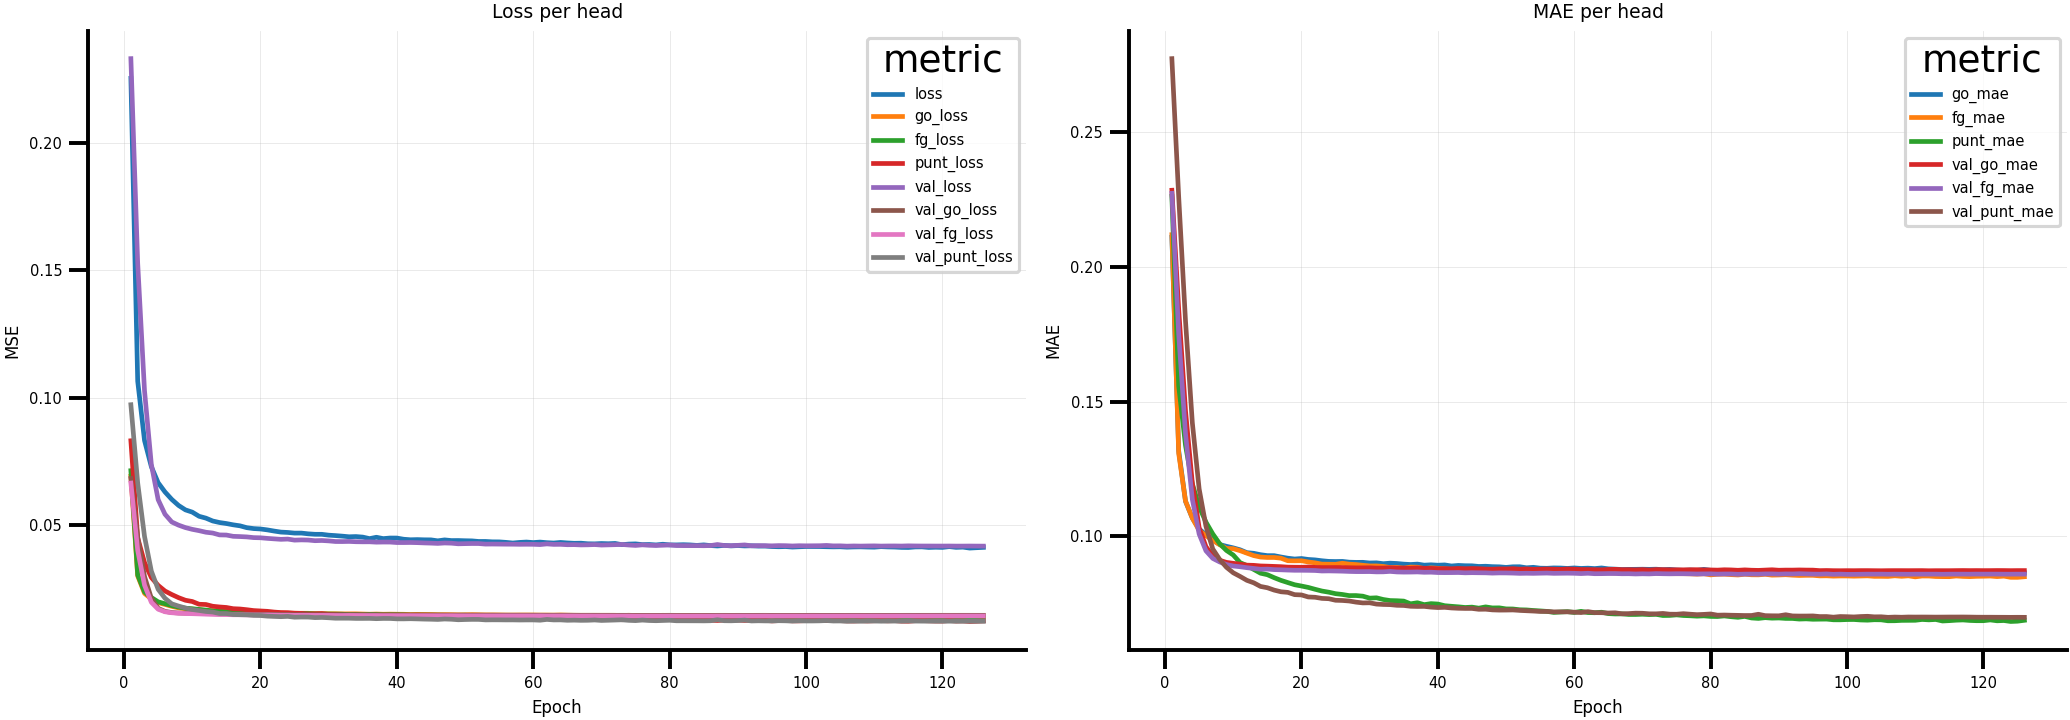

,head,MAE,RMSE
0,GO,0.0873,0.1201
1,FG,0.0860,0.1190
2,PUNT,0.0700,0.1099


,subset,n,agreement
0,All plays,8148,0.784
1,Close & late (≤10 pts & ≤10m),1023,0.861
2,Game-defining (≤8 pts & ≤2m),278,0.885


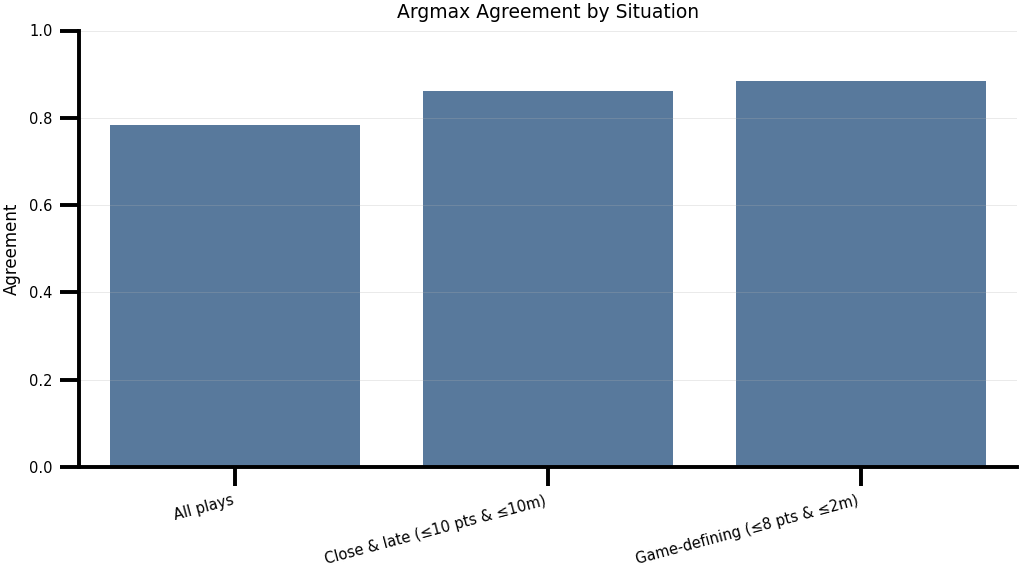

,FIELD_GOAL,GO,PUNT
FIELD_GOAL,0.729,0.213,0.058
GO,0.082,0.697,0.220
PUNT,0.002,0.100,0.897


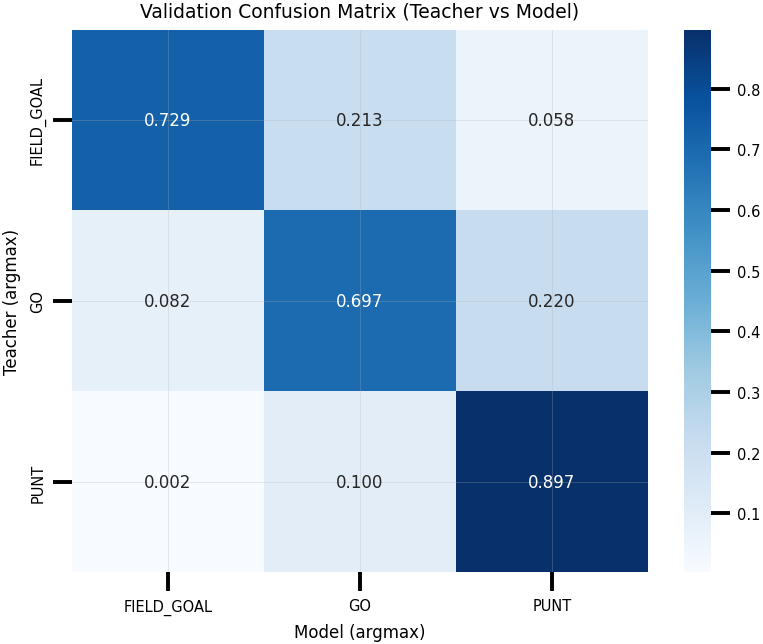

In [24]:
# === MODEL 1 / CELL 3: EVAL ===================================================
# Goal: curves, per-head MAE/RMSE, argmax agreement slices, confusion matrix.

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, confusion_matrix

sns.set_context("talk")
mpl.rcParams.update({
    "font.size": 8, "axes.titlesize": 9, "axes.labelsize": 8,
    "xtick.labelsize": 7, "ytick.labelsize": 7, "legend.fontsize": 7,
    "axes.grid": True, "grid.linewidth": 0.4, "grid.alpha": 0.3,
    "axes.spines.top": False, "axes.spines.right": False,
    "figure.dpi": 150, "savefig.dpi": 300,
    "savefig.bbox": "tight", "savefig.pad_inches": 0.02
})

rmse = lambda yt, yp: root_mean_squared_error(yt, yp)

# 1) Training curves
hist_df = pd.DataFrame(history_wp.history).assign(epoch=lambda d: np.arange(1, len(d)+1))
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

loss_cols = [c for c in ["loss","go_loss","fg_loss","punt_loss","val_loss","val_go_loss","val_fg_loss","val_punt_loss"] if c in hist_df.columns]
mae_cols  = [c for c in ["go_mae","fg_mae","punt_mae","val_go_mae","val_fg_mae","val_punt_mae"] if c in hist_df.columns]

if loss_cols:
    sns.lineplot(data=hist_df.melt("epoch", loss_cols, var_name="metric", value_name="value"),
                 x="epoch", y="value", hue="metric", ax=axes[0])
    axes[0].set_title("Loss per head"); axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("MSE")
else:
    axes[0].axis("off")

if mae_cols:
    sns.lineplot(data=hist_df.melt("epoch", mae_cols, var_name="metric", value_name="value"),
                 x="epoch", y="value", hue="metric", ax=axes[1])
    axes[1].set_title("MAE per head"); axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("MAE")
else:
    axes[1].axis("off")

plt.tight_layout(); plt.show()

# 2) Per-head regression metrics
pred_wp = model_wp.predict(X_val, batch_size=1024, verbose=0)
pred_mat = np.hstack([pred_wp["go"], pred_wp["fg"], pred_wp["punt"]])

rows = []
for j, name in enumerate(["GO","FG","PUNT"]):
    rows.append({"head": name, "MAE": mean_absolute_error(y_val[:, j], pred_mat[:, j]),
                 "RMSE": rmse(y_val[:, j], pred_mat[:, j])})
pd.DataFrame(rows)
display(pd.DataFrame(rows).style.format({"MAE": "{:.4f}", "RMSE": "{:.4f}"}))

# 3) Argmax agreement slices
teacher_arg = np.argmax(y_val, axis=1)
model_arg   = np.argmax(pred_mat, axis=1)

abs_diff  = dfm_val["score_differential"].abs().to_numpy()
secs_left = dfm_val["game_seconds_remaining"].to_numpy()
mask_all  = np.ones(len(dfm_val), dtype=bool)
mask_cl   = (abs_diff <= 10) & (secs_left <= 600)
mask_gd   = (abs_diff <= 8)  & (secs_left <= 120)

def agree(m): 
    return float((teacher_arg[m] == model_arg[m]).mean()) if m.any() else np.nan

subset_agree = pd.DataFrame({
    "subset": ["All plays", "Close & late (≤10 pts & ≤10m)", "Game-defining (≤8 pts & ≤2m)"],
    "n": [int(mask_all.sum()), int(mask_cl.sum()), int(mask_gd.sum())],
    "agreement": [agree(mask_all), agree(mask_cl), agree(mask_gd)]
})
display(subset_agree.style.format({"agreement": "{:.3f}"}))

plt.figure(figsize=(7,4))
sns.barplot(data=subset_agree, x="subset", y="agreement", color="#4C78A8")
plt.ylim(0,1); plt.title("Argmax Agreement by Situation"); plt.xlabel(""); plt.ylabel("Agreement")
plt.xticks(rotation=15, ha="right"); plt.tight_layout(); plt.show()

# 4) Confusion matrix (teacher vs model, displayed as FG/GO/PUNT)
labels = ["FIELD_GOAL", "GO", "PUNT"]
map_disp = {0: 1, 1: 0, 2: 2}  # go->1, fg->0, punt->2
t_disp = np.vectorize(map_disp.get)(teacher_arg)
p_disp = np.vectorize(map_disp.get)(model_arg)

cm = confusion_matrix(t_disp, p_disp, labels=[0,1,2], normalize="true")
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
display(cm_df.style.format("{:.3f}").set_caption("Validation Confusion Matrix (Teacher vs Model)"))
plt.figure(figsize=(5.5,4.5))
sns.heatmap(cm_df, annot=True, fmt=".3f", cmap="Blues")
plt.title("Validation Confusion Matrix (Teacher vs Model)")
plt.ylabel("Teacher (argmax)"); plt.xlabel("Model (argmax)")
plt.tight_layout(); plt.show()


### b) Probabilidad de acertar el go de campo / Probabilidad de convertir la cuarta oportunidad 

#### - Data Prep

In [25]:
# === MODEL 2 / CELL 1: DATA PREP =============================================
# Goal: build features/labels for component probs and prepare grouped split.

import os, json, warnings
import numpy as np
import pandas as pd

from sklearn.model_selection import GroupShuffleSplit

SEED = 42
np.random.seed(SEED)

df = nfl_4th.copy()

# Core distance features & helper bins
df["fg_dist_yd"] = df["yardline_100"] + 17

cuts_y = [0,20,40,60,80,100]
labs_y = ["RZ 0-20","20-40","40-60","60-80","80-100"]
df["yardline_zone"] = pd.cut(df["yardline_100"], bins=cuts_y, labels=labs_y, right=True, include_lowest=True)

cuts_g = [0,2,5,10,99]
labs_g = ["1-2","3-5","6-10","11+"]
df["ytg_bin"] = pd.cut(df["ydstogo"], bins=cuts_g, labels=labs_g, right=True, include_lowest=True)

NUMERIC_FEATURES = [
    "yardline_100", "fg_dist_yd",
    "ydstogo", "qtr", "game_seconds_remaining",
    "score_differential", "posteam_timeouts_remaining", "defteam_timeouts_remaining",
    "two_minute_drill",
]
CATEGORICAL_FEATURES = ["season_type", "roof", "surface", "temp", "wind", "yardline_zone", "ytg_bin"]

TARGETS = ["fg_make_prob", "first_down_prob"]
AVAIL   = ["available_fg", "available_go"]

needed = ["game_id"] + NUMERIC_FEATURES + CATEGORICAL_FEATURES + TARGETS + AVAIL
missing_cols = [c for c in needed if c not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required cols: {missing_cols}")

dfc = df[needed].copy()
for c in CATEGORICAL_FEATURES: dfc[c] = dfc[c].astype("object")

# Very rare NaNs in teacher probs → drop (training targets)
dfc = dfc.dropna(subset=TARGETS, how="any").reset_index(drop=True)

display(dfc.head())
print(f"Shape: {dfc.shape}")
print("Missing values:\n", dfc.isna().sum())


,game_id,yardline_100,fg_dist_yd,ydstogo,qtr,game_seconds_remaining,score_differential,posteam_timeouts_remaining,defteam_timeouts_remaining,two_minute_drill,season_type,roof,surface,temp,wind,yardline_zone,ytg_bin,fg_make_prob,first_down_prob,available_fg,available_go
0,2014_01_BUF_CHI,76.0,93.0,6.0,1.0,3519.0,0.0,3,3,0,REG,open_air,natural,Mild,Light,60-80,6-10,0.000000,0.412740,1,1
1,2014_01_BUF_CHI,65.0,82.0,17.0,1.0,2935.0,0.0,3,3,0,REG,open_air,natural,Mild,Light,60-80,11+,0.000000,0.129922,1,1
2,2014_01_BUF_CHI,44.0,61.0,4.0,2.0,2700.0,0.0,3,3,0,REG,open_air,natural,Mild,Light,40-60,3-5,0.307216,0.476263,1,1
3,2014_01_BUF_CHI,32.0,49.0,6.0,2.0,2292.0,0.0,3,3,0,REG,open_air,natural,Mild,Light,20-40,6-10,0.662561,0.402481,1,1
4,2014_01_BUF_CHI,40.0,57.0,5.0,2.0,1917.0,-10.0,3,3,1,REG,open_air,natural,Mild,Light,20-40,3-5,0.408786,0.481380,1,1


Shape: (40655, 21)
Missing values:
 game_id                       0
yardline_100                  0
fg_dist_yd                    0
ydstogo                       0
qtr                           0
game_seconds_remaining        0
score_differential            0
posteam_timeouts_remaining    0
defteam_timeouts_remaining    0
two_minute_drill              0
season_type                   0
roof                          0
surface                       0
temp                          0
wind                          0
yardline_zone                 0
ytg_bin                       0
fg_make_prob                  0
first_down_prob               0
available_fg                  0
available_go                  0
dtype: int64


#### - Training

In [26]:
# === MODEL 2 / CELL 2: TRAIN ==================================================
# Goal: fit preprocessor on TRAIN ONLY, multi-task Keras (2 sigmoid heads, BCE),
# availability-weighted, persist artifacts.

import joblib, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GroupShuffleSplit

tf.random.set_seed(SEED)
warnings.filterwarnings("ignore", category=UserWarning)

ARTIFACT_DIR = "artifacts_comp"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# 1) Grouped split by game_id
gid = dfc["game_id"].to_numpy()
gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=SEED)
idx_tr, idx_val = next(gss.split(dfc, groups=gid))

# 2) Preprocess
numeric_pipe = Pipeline([("scaler", StandardScaler())])
categorical_pipe = Pipeline([("ohe", OneHotEncoder(drop="if_binary", handle_unknown="ignore"))])
preprocess = ColumnTransformer([("num", numeric_pipe, NUMERIC_FEATURES),
                               ("cat", categorical_pipe, CATEGORICAL_FEATURES)], remainder="drop")

X_tr = preprocess.fit_transform(dfc.iloc[idx_tr][NUMERIC_FEATURES + CATEGORICAL_FEATURES])
X_val = preprocess.transform(dfc.iloc[idx_val][NUMERIC_FEATURES + CATEGORICAL_FEATURES])
if hasattr(X_tr, "toarray"): X_tr = X_tr.toarray()
if hasattr(X_val, "toarray"): X_val = X_val.toarray()
X_tr = X_tr.astype(np.float32); X_val = X_val.astype(np.float32)

y_all = dfc[TARGETS].to_numpy(np.float32)
y_tr, y_val = y_all[idx_tr], y_all[idx_val]
y_tr_dict  = {"fg_make": y_tr[:,0], "go_conv": y_tr[:,1]}
y_val_dict = {"fg_make": y_val[:,0], "go_conv": y_val[:,1]}

avail = dfc[AVAIL].to_numpy(np.float32)
sw_tr = {"fg_make": avail[idx_tr,0], "go_conv": avail[idx_tr,1]}
sw_val = {"fg_make": avail[idx_val,0], "go_conv": avail[idx_val,1]}

# 3) Model
activation = "gelu" if hasattr(tf.keras.activations, "gelu") else "relu"
inp = L.Input(shape=(X_tr.shape[1],), name="features")

h = L.Dense(96, activation=activation, kernel_regularizer=keras.regularizers.l2(1e-5))(inp)
h = L.BatchNormalization()(h); h = L.Dropout(0.10)(h)
h = L.Dense(48, activation=activation, kernel_regularizer=keras.regularizers.l2(1e-5))(h)
h = L.BatchNormalization()(h); h = L.Dropout(0.05)(h)

fg_out = L.Dense(1, activation="sigmoid", name="fg_make")(h)
go_out = L.Dense(1, activation="sigmoid", name="go_conv")(h)

model_comp = keras.Model(inp, {"fg_make": fg_out, "go_conv": go_out}, name="comp_multitask")

try:
    opt = keras.optimizers.AdamW(learning_rate=3e-4, weight_decay=1e-5)
except Exception:
    opt = keras.optimizers.Adam(learning_rate=3e-4)

model_comp.compile(
    optimizer=opt,
    loss={"fg_make": "binary_crossentropy", "go_conv": "binary_crossentropy"},
    metrics={"fg_make": [keras.metrics.MeanAbsoluteError(name="mae")],
             "go_conv": [keras.metrics.MeanAbsoluteError(name="mae")]}
)

cbs = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=8, factor=0.5, min_lr=1e-5),
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(ARTIFACT_DIR, "comp_multitask.best.weights.h5"),
        monitor="val_loss", save_best_only=True, save_weights_only=True, verbose=1
    ),
]

history_comp = model_comp.fit(
    X_tr, y_tr_dict,
    sample_weight=sw_tr,
    validation_data=(X_val, y_val_dict, sw_val),
    epochs=150, batch_size=512, verbose=1, callbacks=cbs,
)

# 4) Persist artifacts
joblib.dump(preprocess, os.path.join(ARTIFACT_DIR, "preprocess.joblib"))
meta = {
    "seed": SEED,
    "numeric_features": NUMERIC_FEATURES,
    "categorical_features": CATEGORICAL_FEATURES,
    "targets": TARGETS,
    "heads": {"fg_make": 0, "go_conv": 1},
    "input_dim": int(X_tr.shape[1]),
}
with open(os.path.join(ARTIFACT_DIR, "feature_meta.json"), "w") as f: json.dump(meta, f, indent=2)
try:
    feat_names = preprocess.get_feature_names_out().tolist()
    with open(os.path.join(ARTIFACT_DIR, "preprocess_feature_names.json"), "w") as f:
        json.dump(feat_names, f, indent=2)
except Exception: pass

model_comp.save_weights(os.path.join(ARTIFACT_DIR, "comp_multitask.last.weights.h5"))


Epoch 1/150
55/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - fg_make_loss: 0.5737 - fg_make_mae: 0.2940 - go_conv_loss: 0.8593 - go_conv_mae: 0.2416 - loss: 1.4342  
Epoch 1: val_loss improved from inf to 1.09205, saving model to artifacts_comp/comp_multitask.best.weights.h5
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - fg_make_loss: 0.5541 - fg_make_mae: 0.2826 - go_conv_loss: 0.8467 - go_conv_mae: 0.2361 - loss: 1.4019 - val_fg_make_loss: 0.4216 - val_fg_make_mae: 0.2530 - val_go_conv_loss: 0.6694 - val_go_conv_mae: 0.1599 - val_loss: 1.0920 - learning_rate: 3.0000e-04
Epoch 2/150
52/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - fg_make_loss: 0.2927 - fg_make_mae: 0.1174 - go_conv_loss: 0.6738 - go_conv_mae: 0.1478 - loss: 0.9675
Epoch 2: val_loss improved from 1.09205 to 0.95124, saving model to artifacts_comp/comp_multitask.best.weights.h5
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - fg_make_loss: 0.2913 - fg_make_mae: 0.1160 - go_conv_loss: 0.6717 - go_conv_mae: 0.1460 - loss: 0.9641 - val_fg_make_loss: 0

#### - Evaulación

,head,MAE,RMSE,R2,MSE
0,fg_make,0.006958,0.022364,0.996700,0.022364
1,go_conv,0.020566,0.026575,0.977158,0.026575


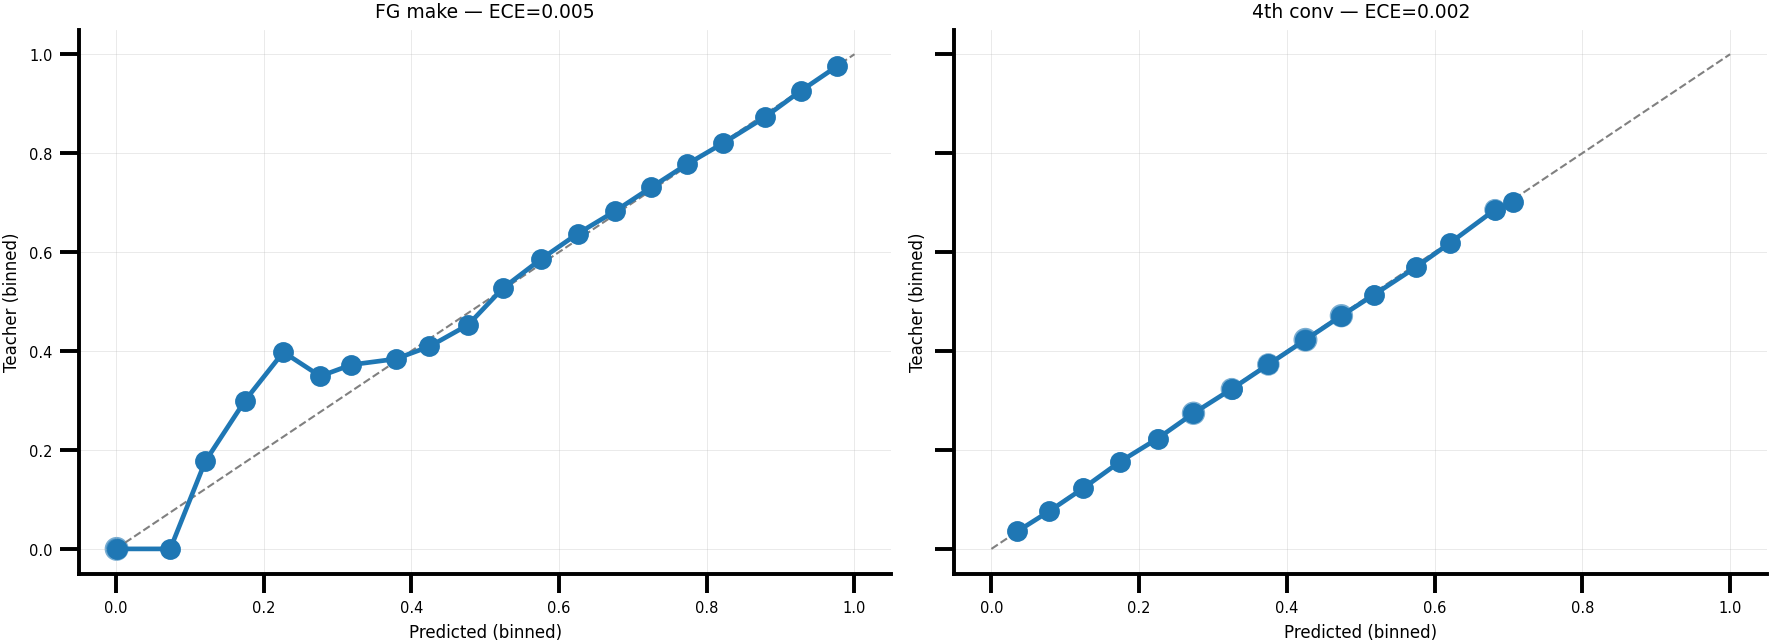

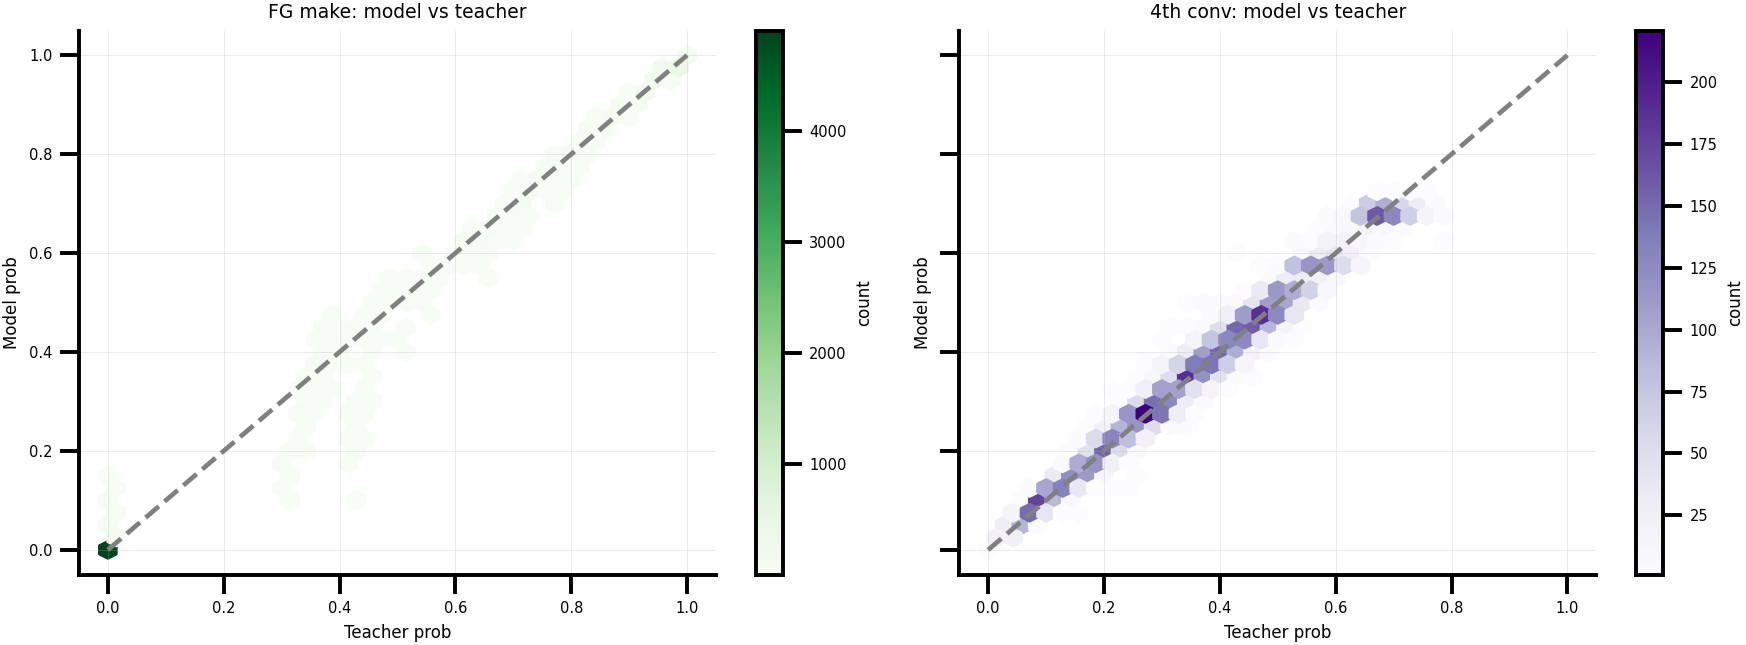

,subset,fg_MAE,go_MAE,n_fg,n_go
0,All plays,0.0070,0.0206,8148,8148
1,Close & late (≤10 pts & ≤10m),0.0074,0.0203,1023,1023
2,Game-defining (≤8 pts & ≤2m),0.0074,0.0216,278,278


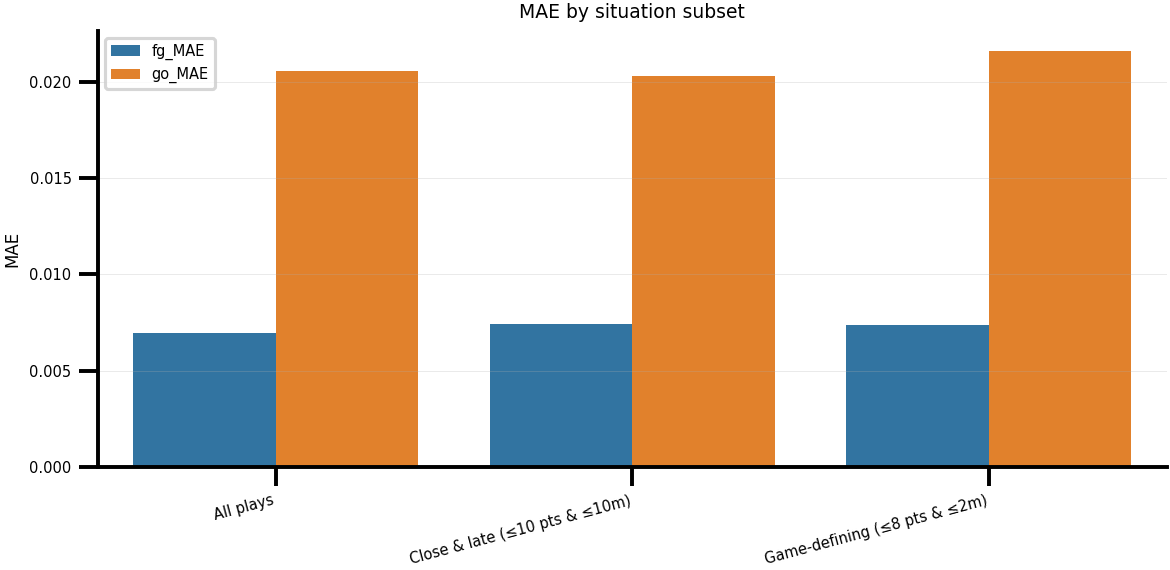

In [27]:
# === MODEL 2 / CELL 3: EVAL ===================================================
# Goal: MAE/RMSE, calibration curves (ECE), hexbin teacher vs model, and
# subset MAE in (All / Close&Late / Game-defining).

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

sns.set_context("talk")
mpl.rcParams.update({
    "font.size": 8, "axes.titlesize": 9, "axes.labelsize": 8,
    "xtick.labelsize": 7, "ytick.labelsize": 7, "legend.fontsize": 7,
    "axes.grid": True, "grid.linewidth": 0.4, "grid.alpha": 0.3,
    "axes.spines.top": False, "axes.spines.right": False,
    "figure.dpi": 150, "savefig.dpi": 300,
    "savefig.bbox": "tight", "savefig.pad_inches": 0.02
})
rmse = lambda yt, yp: root_mean_squared_error(yt, yp)

# 1) Predictions
pred_val = model_comp.predict(X_val, batch_size=1024, verbose=0)
p_fg = pred_val["fg_make"].ravel()
p_go = pred_val["go_conv"].ravel()
t_fg = y_val[:, 0]; t_go = y_val[:, 1]

val_df = dfc.iloc[idx_val].reset_index(drop=True)
m_fg = val_df["available_fg"].to_numpy().astype(bool)
m_go = val_df["available_go"].to_numpy().astype(bool)

# 2) Overall metrics
def reg_metrics(y_true, y_pred, m=None):
    if m is not None: y_true, y_pred = y_true[m], y_pred[m]
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": rmse(y_true, y_pred),
        "R2": r2_score(y_true, y_pred),
        "MSE": root_mean_squared_error(y_true, y_pred),
    }
overall = pd.DataFrame([
    {"head": "fg_make", **reg_metrics(t_fg, p_fg, m_fg)},
    {"head": "go_conv", **reg_metrics(t_go, p_go, m_go)},
])
display(overall.style.format({k:"{:.4f}"}).set_caption("Overall Validation Metrics"))

# 3) Calibration / ECE
def calibration_df(y_true, y_pred, bins=np.linspace(0,1,21), mask=None):
    if mask is not None: y_true, y_pred = y_true[mask], y_pred[mask]
    dd = pd.DataFrame({"y_true": y_true, "y_pred": y_pred})
    dd["bin"] = pd.cut(dd["y_pred"], bins=bins, include_lowest=True)
    g = dd.groupby("bin", observed=True).agg(pred_mean=("y_pred","mean"),
                                             true_mean=("y_true","mean"),
                                             count=("y_true","size")).dropna().reset_index()
    N = g["count"].sum(); g["ece_term"] = (g["count"]/N) * (g["pred_mean"] - g["true_mean"]).abs()
    return g, g["ece_term"].sum()

cal_fg, ece_fg = calibration_df(t_fg, p_fg, mask=m_fg)
cal_go, ece_go = calibration_df(t_go, p_go, mask=m_go)

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharex=True, sharey=True)
for ax, cal, ttl in [(axes[0], cal_fg, f"FG make — ECE={ece_fg:.3f}"),
                     (axes[1], cal_go, f"4th conv — ECE={ece_go:.3f}")]:
    ax.plot([0,1],[0,1], ls="--", c="gray", lw=1)
    ax.plot(cal["pred_mean"], cal["true_mean"], marker="o")
    sizes = 100 * (cal["count"]/cal["count"].max()).clip(0.2, None)
    ax.scatter(cal["pred_mean"], cal["true_mean"], s=sizes, alpha=0.6)
    ax.set_xlabel("Predicted (binned)"); ax.set_ylabel("Teacher (binned)"); ax.set_title(ttl)
plt.tight_layout(); plt.show()

# 4) Teacher vs Model — hexbin
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharex=True, sharey=True)
hb1 = axes[0].hexbin(t_fg[m_fg], p_fg[m_fg], gridsize=35, extent=(0,1,0,1), mincnt=1, cmap="Greens")
axes[0].plot([0,1],[0,1],"--",c="gray"); axes[0].set_title("FG make: model vs teacher")
fig.colorbar(hb1, ax=axes[0], label="count")
hb2 = axes[1].hexbin(t_go[m_go], p_go[m_go], gridsize=35, extent=(0,1,0,1), mincnt=1, cmap="Purples")
axes[1].plot([0,1],[0,1],"--",c="gray"); axes[1].set_title("4th conv: model vs teacher")
fig.colorbar(hb2, ax=axes[1], label="count")
for ax in axes:
    ax.set_xlabel("Teacher prob"); ax.set_ylabel("Model prob")
plt.tight_layout(); plt.show()

# 5) Situation-aware MAE
abs_diff  = val_df["score_differential"].abs().to_numpy()
secs_left = val_df["game_seconds_remaining"].to_numpy()
mask_all  = np.ones_like(m_fg, dtype=bool)
mask_cl   = (abs_diff <= 10) & (secs_left <= 600)
mask_gd   = (abs_diff <= 8)  & (secs_left <= 120)

def masked_mae(y_true, y_pred, avail, sit):
    sel = avail & sit
    return float(mean_absolute_error(y_true[sel], y_pred[sel])) if sel.any() else np.nan

rows = []
for nm, sm in [("All plays", mask_all), ("Close & late (≤10 pts & ≤10m)", mask_cl), ("Game-defining (≤8 pts & ≤2m)", mask_gd)]:
    rows.append({
        "subset": nm,
        "fg_MAE": masked_mae(t_fg, p_fg, m_fg, sm),
        "go_MAE": masked_mae(t_go, p_go, m_go, sm),
        "n_fg": int((m_fg & sm).sum()),
        "n_go": int((m_go & sm).sum()),
    })
sit_df = pd.DataFrame(rows)
display(sit_df.style.format({"fg_MAE":"{:.4f}","go_MAE":"{:.4f}"}))

plt.figure(figsize=(8,4))
sns.barplot(data=sit_df.melt("subset", ["fg_MAE","go_MAE"], var_name="head", value_name="MAE"),
            x="subset", y="MAE", hue="head")
plt.title("MAE by situation subset"); plt.xlabel(""); plt.ylabel("MAE")
plt.xticks(rotation=15, ha="right"); plt.legend(title=""); plt.tight_layout(); plt.show()


### c) Modelo de comportamiento (simulación de coach)

#### - Data Prep

In [28]:
# === MODEL 3 / CELL 1: DATA PREP =============================================
# Goal: build features for behavior classification (GO/FG/PUNT), labels, eval helpers.

import os, json, warnings
import numpy as np
import pandas as pd

SEED = 42
np.random.seed(SEED)

# Situational flags (idempotent)
nfl_4th["is_fg_range"] = ((nfl_4th["yardline_100"] + 17) <= 67).astype(int)
nfl_4th["fg_puts_ties_or_leads"] = nfl_4th["score_differential"].between(-3, 0).astype(int)
nfl_4th["is_game_deciding"] = (
    (nfl_4th["score_differential"].abs() <= 8) &
    (nfl_4th["game_seconds_remaining"] <= 120) &
    (nfl_4th["qtr"] == 4)
).astype(int)
nfl_4th["is_losing_by_one_score"] = (
    (nfl_4th["score_differential"] < 0) &
    (nfl_4th["score_differential"] >= -8)
).astype(int)

NUMERIC_FEATURES = [
    "yardline_100", "ydstogo", "qtr", "game_seconds_remaining",
    "score_differential", "posteam_timeouts_remaining", "defteam_timeouts_remaining",
    "two_minute_drill", "is_fg_range", "fg_puts_ties_or_leads",
    "is_game_deciding", "is_losing_by_one_score",
]
CATEGORICAL_FEATURES = ["season_type", "roof", "surface", "temp", "wind"]
TARGET_WP_COLS = ["go_wp", "fg_wp", "punt_wp"]

VALID_ACTIONS = {"GO", "FIELD_GOAL", "PUNT"}
mask_valid = nfl_4th["actual_action"].isin(VALID_ACTIONS)

df_coach = nfl_4th.loc[mask_valid, ["game_id"] + NUMERIC_FEATURES + CATEGORICAL_FEATURES + ["actual_action"] + TARGET_WP_COLS].copy()
for c in CATEGORICAL_FEATURES: df_coach[c] = df_coach[c].astype("object")

CLASS_ORDER = ["GO", "FIELD_GOAL", "PUNT"]  # 0,1,2 (aligns to [go_wp, fg_wp, punt_wp])
label_map = {c:i for i,c in enumerate(CLASS_ORDER)}
df_coach["y_cls"] = df_coach["actual_action"].map(label_map).astype(int)

wp_mat = df_coach[TARGET_WP_COLS].to_numpy(float)
df_coach["teacher_arg"] = wp_mat.argmax(axis=1)
top = wp_mat.max(axis=1); second = np.partition(wp_mat, -2, axis=1)[:, -2]
df_coach["teacher_margin_top2"] = top - second

display(df_coach.head())
print(f"Rows for behavior modeling: {len(df_coach):,}")
print("Class distribution:\n", df_coach["actual_action"].value_counts())
print("\nMissing values in features:\n", df_coach[NUMERIC_FEATURES + CATEGORICAL_FEATURES].isna().sum())


,game_id,yardline_100,ydstogo,qtr,game_seconds_remaining,score_differential,posteam_timeouts_remaining,defteam_timeouts_remaining,two_minute_drill,is_fg_range,fg_puts_ties_or_leads,is_game_deciding,is_losing_by_one_score,season_type,roof,surface,temp,wind,actual_action,go_wp,fg_wp,punt_wp,y_cls,teacher_arg,teacher_margin_top2
0,2014_01_BUF_CHI,76.0,6.0,1.0,3519.0,0.0,3,3,0,0,1,0,0,REG,open_air,natural,Mild,Light,PUNT,0.205945,0.155812,0.217337,2,2,0.011393
1,2014_01_BUF_CHI,65.0,17.0,1.0,2935.0,0.0,3,3,0,0,1,0,0,REG,open_air,natural,Mild,Light,PUNT,0.694638,0.654108,0.733610,2,2,0.038972
2,2014_01_BUF_CHI,44.0,4.0,2.0,2700.0,0.0,3,3,0,1,1,0,0,REG,open_air,natural,Mild,Light,PUNT,0.303086,0.278493,0.282596,2,0,0.020489
3,2014_01_BUF_CHI,32.0,6.0,2.0,2292.0,0.0,3,3,0,1,1,0,0,REG,open_air,natural,Mild,Light,FIELD_GOAL,0.321526,0.324930,0.275911,1,1,0.003404
4,2014_01_BUF_CHI,40.0,5.0,2.0,1917.0,-10.0,3,3,1,1,0,0,0,REG,open_air,natural,Mild,Light,PUNT,0.402769,0.346008,0.363502,2,0,0.039266


Rows for behavior modeling: 40,655
Class distribution:
 PUNT          23455
FIELD_GOAL     9609
GO             7591
Name: actual_action, dtype: int64

Missing values in features:
 yardline_100                  0
ydstogo                       0
qtr                           0
game_seconds_remaining        0
score_differential            0
posteam_timeouts_remaining    0
defteam_timeouts_remaining    0
two_minute_drill              0
is_fg_range                   0
fg_puts_ties_or_leads         0
is_game_deciding              0
is_losing_by_one_score        0
season_type                   0
roof                          0
surface                       0
temp                          0
wind                          0
dtype: int64


#### - Entrenamiento

In [29]:
# === MODEL 3 / CELL 2: TRAIN ==================================================
# Goal: grouped split, preprocess (TRAIN ONLY), softmax classifier with weights,
# and persist artifacts.

import joblib, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils.class_weight import compute_class_weight

tf.random.set_seed(SEED)
warnings.filterwarnings("ignore", category=UserWarning)

ARTIFACT_DIR = "artifacts_coach"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# 1) Grouped split by game_id
gid = df_coach["game_id"].to_numpy()
gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=SEED)
idx_tr, idx_val = next(gss.split(df_coach, groups=gid))

# 2) Preprocess (fit on TRAIN ONLY)
numeric_pipe = Pipeline([("scaler", StandardScaler())])
categorical_pipe = Pipeline([("ohe", OneHotEncoder(drop="if_binary", handle_unknown="ignore"))])
preprocess = ColumnTransformer([("num", numeric_pipe, NUMERIC_FEATURES),
                               ("cat", categorical_pipe, CATEGORICAL_FEATURES)], remainder="drop")

X_tr = preprocess.fit_transform(df_coach.iloc[idx_tr][NUMERIC_FEATURES + CATEGORICAL_FEATURES])
X_val = preprocess.transform(df_coach.iloc[idx_val][NUMERIC_FEATURES + CATEGORICAL_FEATURES])
if hasattr(X_tr, "toarray"): X_tr = X_tr.toarray()
if hasattr(X_val, "toarray"): X_val = X_val.toarray()
X_tr = X_tr.astype(np.float32); X_val = X_val.astype(np.float32)

y_tr = df_coach.iloc[idx_tr]["y_cls"].to_numpy(int)
y_val = df_coach.iloc[idx_val]["y_cls"].to_numpy(int)

# 3) Class weights
classes = np.array([0,1,2], dtype=int)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_tr)
class_weight = {int(k): float(v) for k, v in zip(classes, cw)}
print("Class weights:", class_weight)

# 4) Model
activation = "gelu" if hasattr(tf.keras.activations, "gelu") else "relu"
inp = L.Input(shape=(X_tr.shape[1],), name="features")
x = L.Dense(128, activation=activation, kernel_regularizer=keras.regularizers.l2(1e-5))(inp)
x = L.BatchNormalization()(x); x = L.Dropout(0.20)(x)
x = L.Dense(64, activation=activation, kernel_regularizer=keras.regularizers.l2(1e-5))(x)
x = L.BatchNormalization()(x); x = L.Dropout(0.15)(x)
x = L.Dense(32, activation=activation)(x)
out = L.Dense(3, activation="softmax", name="coach_policy")(x)

model_coach = keras.Model(inp, out, name="coach_policy_classifier")
try:
    opt = keras.optimizers.AdamW(learning_rate=3e-4, weight_decay=1e-5)
except Exception:
    opt = keras.optimizers.Adam(learning_rate=3e-4)

model_coach.compile(optimizer=opt, loss="sparse_categorical_crossentropy",
                    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")])

ckpt_path = os.path.join(ARTIFACT_DIR, "coach_policy.best.weights.h5")
cbs = [
    keras.callbacks.EarlyStopping(monitor="val_acc", patience=15, restore_best_weights=True, mode="max"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_acc", patience=7, factor=0.5, min_lr=1e-5, mode="max"),
    keras.callbacks.ModelCheckpoint(filepath=ckpt_path, monitor="val_acc",
                                    save_best_only=True, save_weights_only=True, mode="max", verbose=1),
]

history_coach = model_coach.fit(
    X_tr, y_tr, validation_data=(X_val, y_val),
    epochs=200, batch_size=512, verbose=1,
    class_weight=class_weight, callbacks=cbs,
)

# 5) Persist artifacts
joblib.dump(preprocess, os.path.join(ARTIFACT_DIR, "preprocess.joblib"))
meta = {
    "seed": SEED,
    "numeric_features": NUMERIC_FEATURES,
    "categorical_features": CATEGORICAL_FEATURES,
    "class_order": ["GO", "FIELD_GOAL", "PUNT"],
    "input_dim": int(X_tr.shape[1]),
}
with open(os.path.join(ARTIFACT_DIR, "feature_meta.json"), "w") as f: json.dump(meta, f, indent=2)
try:
    feat_names = preprocess.get_feature_names_out().tolist()
    with open(os.path.join(ARTIFACT_DIR, "preprocess_feature_names.json"), "w") as f:
        json.dump(feat_names, f, indent=2)
except Exception: pass

model_coach.save_weights(os.path.join(ARTIFACT_DIR, "coach_policy.last.weights.h5"))


Class weights: {0: 1.7690884353741496, 1: 1.3968888315929697, 2: 0.5817807606263982}
Epoch 1/200
47/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.3889 - loss: 1.1920   
Epoch 1: val_acc improved from -inf to 0.76694, saving model to artifacts_coach/coach_policy.best.weights.h5
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.4272 - loss: 1.1289 - val_acc: 0.7669 - val_loss: 0.8523 - learning_rate: 3.0000e-04
Epoch 2/200
46/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7190 - loss: 0.6953
Epoch 2: val_acc improved from 0.76694 to 0.79897, saving model to artifacts_coach/coach_policy.best.weights.h5
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.7224 - loss: 0.6898 - val_acc: 0.7990 - val_loss: 0.6706 - learning_rate: 3.0000e-04
Epoch 3/200
60/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.7601 - loss: 0.6165
Epoch 3: val_acc improved from 0.79897 to 0.82339, saving model to artifacts_coach/coach_policy.best.weights.h5
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.7604 - loss: 0.6163 - val

#### - Evaluación

Validation Accuracy: 0.884 | Macro-F1: 0.841

              precision    recall  f1-score   support

          GO      0.709     0.668     0.688      1466
  FIELD_GOAL      0.889     0.917     0.902      1852
        PUNT      0.931     0.936     0.934      4830

    accuracy                          0.884      8148
   macro avg      0.843     0.840     0.841      8148
weighted avg      0.882     0.884     0.882      8148



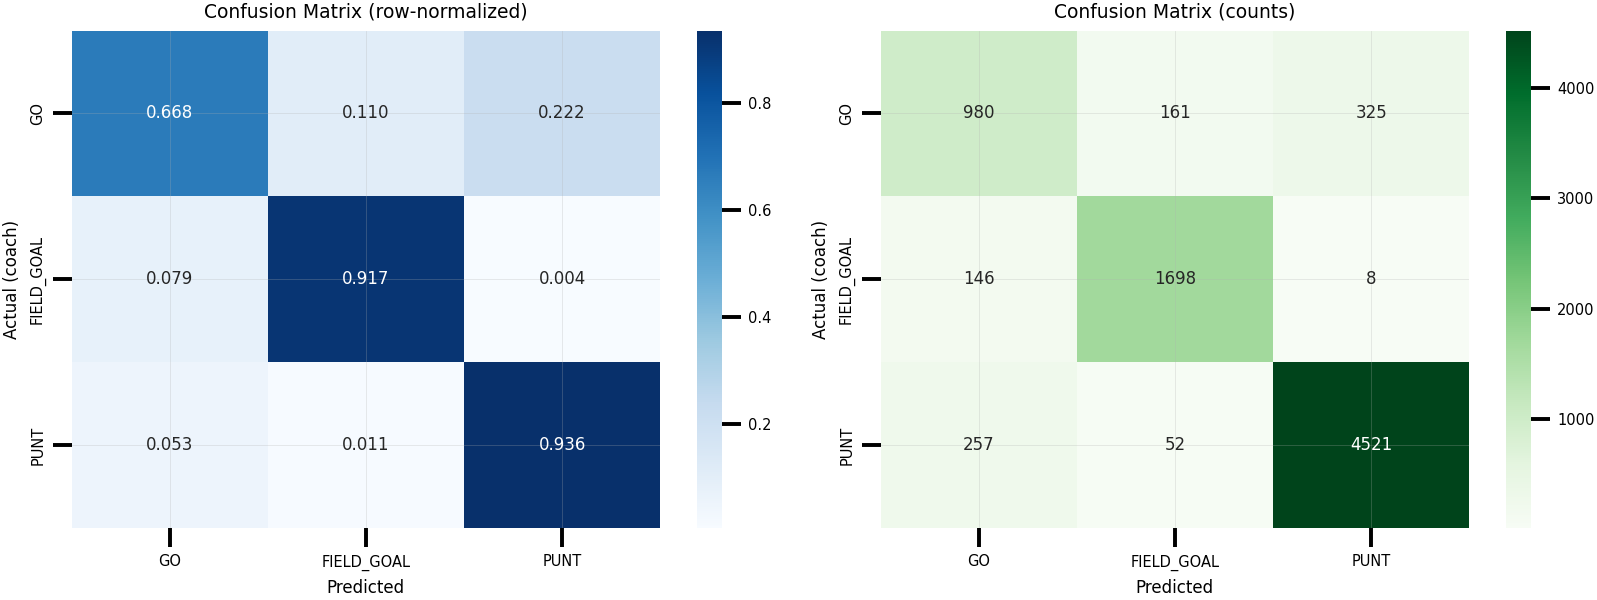

Mean P_coach(opt_action) on validation: 0.502


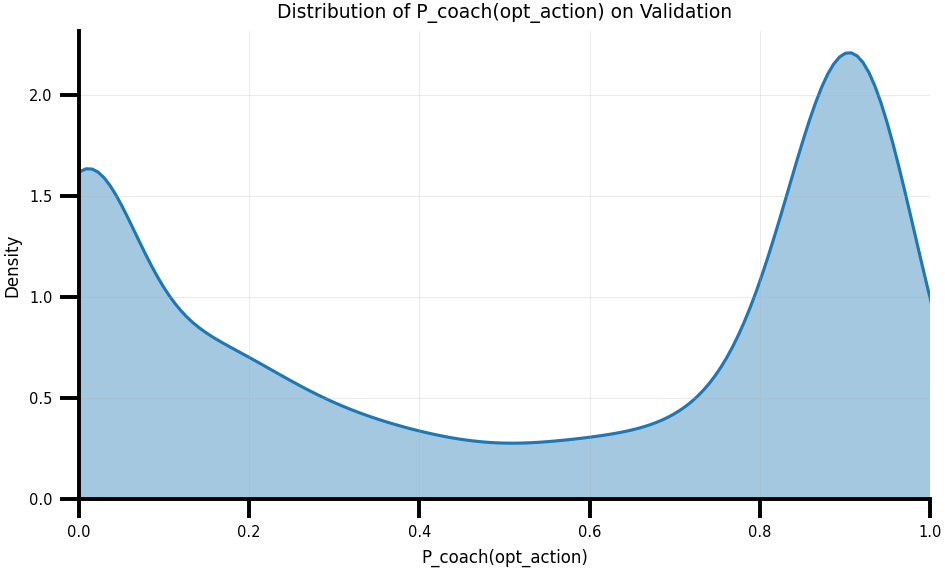

,subset,n,P_coach_opt_mean,acc_actual,agree_teacher
0,All plays,8148,0.502,0.884,0.529
1,Close & late (≤10 pts & ≤10m),1023,0.472,0.860,0.524
2,Game-defining (≤8 pts & ≤2m),278,0.431,0.888,0.457


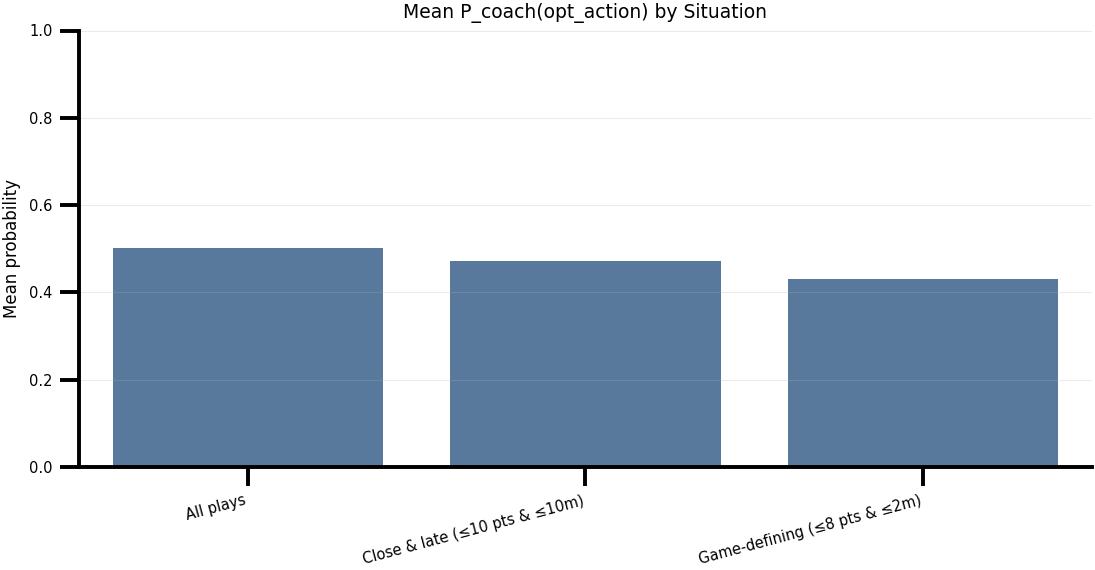

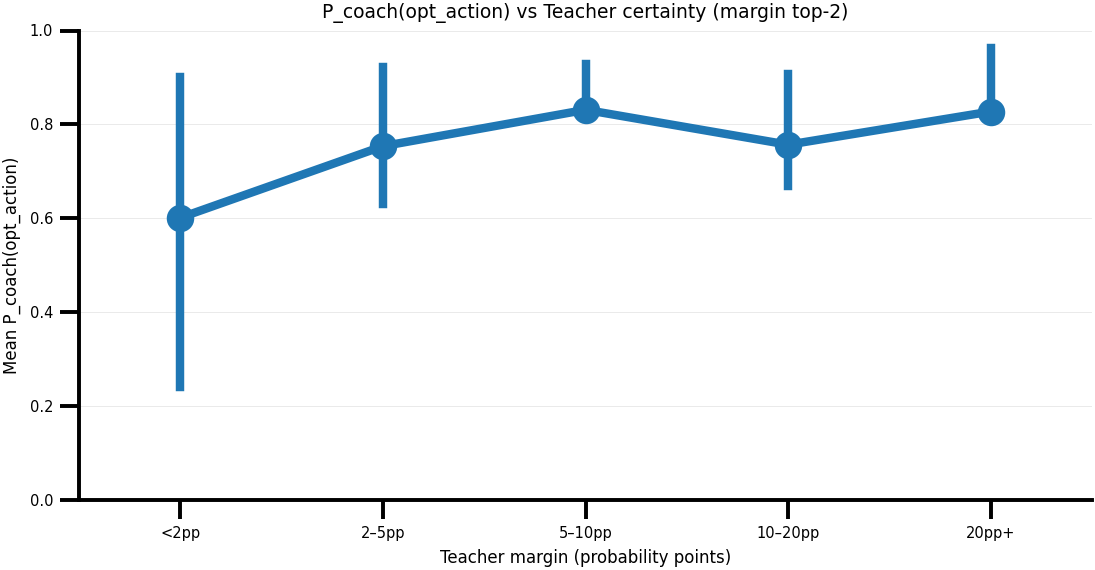

In [30]:
# === MODEL 3 / CELL 3: EVAL ===================================================
# Goal: accuracy/F1, confusion matrices, P_coach(opt_action) + situation slices.

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, accuracy_score
)

sns.set_context("talk")
mpl.rcParams.update({
    "font.size": 8, "axes.titlesize": 9, "axes.labelsize": 8,
    "xtick.labelsize": 7, "ytick.labelsize": 7, "legend.fontsize": 7,
    "axes.grid": True, "grid.linewidth": 0.4, "grid.alpha": 0.3,
    "axes.spines.top": False, "axes.spines.right": False,
    "figure.dpi": 150, "savefig.dpi": 300,
    "savefig.bbox": "tight", "savefig.pad_inches": 0.02
})

# 1) Predictions
probs_val = model_coach.predict(X_val, batch_size=1024, verbose=0)
pred_val  = probs_val.argmax(axis=1)
labels = ["GO", "FIELD_GOAL", "PUNT"]

# 2) Basic metrics
acc = accuracy_score(y_val, pred_val)
f1_macro = f1_score(y_val, pred_val, average="macro")
print(f"Validation Accuracy: {acc:.3f} | Macro-F1: {f1_macro:.3f}\n")
print(classification_report(y_val, pred_val, target_names=labels, digits=3))

cm_norm = confusion_matrix(y_val, pred_val, labels=[0,1,2], normalize="true")
cm_raw  = confusion_matrix(y_val, pred_val, labels=[0,1,2])

fig, axes = plt.subplots(1, 2, figsize=(11, 4.2))
sns.heatmap(pd.DataFrame(cm_norm, index=labels, columns=labels), annot=True, fmt=".3f",
            cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix (row-normalized)")
axes[0].set_ylabel("Actual (coach)"); axes[0].set_xlabel("Predicted")

sns.heatmap(pd.DataFrame(cm_raw, index=labels, columns=labels), annot=True, fmt="d",
            cmap="Greens", ax=axes[1])
axes[1].set_title("Confusion Matrix (counts)")
axes[1].set_ylabel("Actual (coach)"); axes[1].set_xlabel("Predicted")
plt.tight_layout(); plt.show()

# 3) P_coach(opt_action)
df_val = df_coach.iloc[idx_val].reset_index(drop=True)
teacher_arg_val = df_val["teacher_arg"].to_numpy()
p_coach_opt = probs_val[np.arange(len(probs_val)), teacher_arg_val]
print(f"Mean P_coach(opt_action) on validation: {p_coach_opt.mean():.3f}")

plt.figure(figsize=(6.5, 4))
sns.kdeplot(p_coach_opt, fill=True, alpha=0.4)
plt.title("Distribution of P_coach(opt_action) on Validation")
plt.xlabel("P_coach(opt_action)"); plt.xlim(0, 1)
plt.tight_layout(); plt.show()

# 4) Situation subsets
abs_diff  = df_val["score_differential"].abs().to_numpy()
secs_left = df_val["game_seconds_remaining"].to_numpy()
mask_all  = np.ones(len(df_val), dtype=bool)
mask_cl   = (abs_diff <= 10) & (secs_left <= 600)
mask_gd   = (abs_diff <= 8)  & (secs_left <= 120)

def subset_stats(mask):
    return {
        "n": int(mask.sum()),
        "P_coach_opt_mean": float(p_coach_opt[mask].mean()) if mask.any() else np.nan,
        "acc_actual": float(accuracy_score(y_val[mask], pred_val[mask])) if mask.any() else np.nan,
        "agree_teacher": float((pred_val[mask] == teacher_arg_val[mask]).mean()) if mask.any() else np.nan,
    }

summary = pd.DataFrame.from_dict({
    "All plays": subset_stats(mask_all),
    "Close & late (≤10 pts & ≤10m)": subset_stats(mask_cl),
    "Game-defining (≤8 pts & ≤2m)": subset_stats(mask_gd),
}, orient="index").reset_index(names="subset")

display(summary.style.format({"P_coach_opt_mean": "{:.3f}", "acc_actual": "{:.3f}", "agree_teacher": "{:.3f}"}))

plt.figure(figsize=(7.5, 4))
sns.barplot(data=summary, x="subset", y="P_coach_opt_mean", color="#4C78A8")
plt.ylim(0,1); plt.title("Mean P_coach(opt_action) by Situation")
plt.xlabel(""); plt.ylabel("Mean probability"); plt.xticks(rotation=15, ha="right")
plt.tight_layout(); plt.show()

# 5) Optional: P_coach(opt_action) vs teacher certainty (top-2 margin)
bins = [0, 0.02, 0.05, 0.10, 0.20, 1.0]
labels_bins = ["<2pp", "2–5pp", "5–10pp", "10–20pp", "20pp+"]
df_margin = pd.DataFrame({
    "margin": df_val["teacher_margin_top2"].to_numpy(),
    "p_coach_opt": p_coach_opt
}).assign(margin_bin=lambda d: pd.cut(d["margin"], bins=bins, labels=labels_bins, include_lowest=True))

plt.figure(figsize=(7.5, 4))
sns.pointplot(data=df_margin, x="margin_bin", y="p_coach_opt", errorbar=("pi", 50))
plt.ylim(0,1); plt.title("P_coach(opt_action) vs Teacher certainty (margin top-2)")
plt.xlabel("Teacher margin (probability points)"); plt.ylabel("Mean P_coach(opt_action)")
plt.tight_layout(); plt.show()
